# Criteo Click Through Rate Prediction 
Final project for W261 - Machine Learning at Scale  
By Ben Arnoldy, Kenneth Chen, Nick Conidas, Rohini Kashibatla, Pavan Kurapati

Criteo is a company that uses machine learning to serve up web advertising. In 2014, the company launched the [Click Through Rate (CTR) prediction competition](https://www.kaggle.com/c/criteo-display-ad-challenge) hosted on Kaggle. The group with the lowest loss score won. Our team is working on this challenge for our W261 class at UC Berkeley in order to showcase a semester of learning.

## 1: Question Formulation  
_Introduce the goal of your analysis. What questions will you seek to answer, why do people perform this kind of analysis on this kind of data? Preview what level of performance your model would need to achieve to be practically useful._

The overall question we are trying to answer is, given a set of information about a particular website visitor, session, ad, etc., will that visitor click the ad we serve?  
  
A company like Criteo could then use the answer to that question to decide which ad out of a series of possible ads to serve in a particular location during a particular session. Companies like Criteo are paid by advertisers at some rate per user click, so to maximize revenue, Criteo would serve the ad that maximizes (CTR * pay per click). If we can predict CTR accurately -- which is the goal of this competition -- Criteo can find the ad that will maximize their revenue.  
  
This has huge implications because online advertising is a giant industry.  
  
Spending on digital advertising globally is projected to be $327.28 billion in 2019, according to [eMarketer](https://www.emarketer.com/content/global-ad-spending-update).  
  
In order for this machine learning prediction to be useful, it must meet a few criteria:  
  
1. The prediction must happen in a split second. No one wants to wait for webpages to load but this prediction must happen at load time. So algorithm must ingest all the relevant feature data -- info about the user, the session, the ad, etc. -- plug it into the model and return a verdict, and then do that across all potential ads the company can serve, then pick the ad that will maximize revenue and serve it on the page. The pace required immediately rules out learning algorithms like K-Means where you can't pre-train a model. 
2. For companies like Criteo that are serving ads, it doesn't matter all that much _why_ certain ads have higher CTR; it's just crucial to know _which_ ads will. So, interpretability of the model isn't critical here, opening up the range of algorithms to things like neural nets and random forests. Criteo's customers, of course, would love to have an interpretable model so they could make more effective web ads, but that's a different use case.  
3. Web advertising companies are serving a lot of web ad impressions, and most of the time ads go unclicked. And there are a lot of possible features to track in the online space. So we need a lot of data to find something meaningful out of the high-dimensional and sparse data. Fortunately, we have it: the Criteo dataset for this competition has 45 million rows and represents just a week's worth of ad serves. Unfortunately, data on this scale is challenging to work with.
4. Whatever model we train will be quickly out of data given the rapid pace of changes in Internet behavior and the growing amount of data that can be used to improve models. That said, it's not clear that the model needs to be an online model where things are changing so fast that it must update instantly as more data streams in. The model training could happen offline in a matter of hours, even days, and still be okay. 

## 2: Algorithm Explanation
_Create your own toy example that matches the dataset provided and use this toy example to explain the math behind the algorithm that you will perform._  

Logistic regression carries over some of the same concepts as linear regression but with some important differences. Fundamentally, we are still training a model using the equation for a line, and the model is the set of coefficients or weights. 

\begin{equation}\tag{2.1}
y = \beta_0 + \beta_1 \cdot x_1 ... + \beta_m \cdot x_m
\end{equation}
  
\begin{equation}\tag{2.2}
w = [\beta_0, \beta_1, ... \beta_m]
\end{equation}  
  
where $m$ is number of features, $\beta_0$ is the intercept or bias term, and $w$ are the weights of our model.  
  
We aren't training on just one sample, of course, but over many, so the weights are actually calculated over many rows $x$'s and $y$'s.   
  
\begin{equation}\tag{2.3}
y_j = \displaystyle\sum_{i=1}^{m}{w_i\cdot x_{ji} + b}
\end{equation}  
  
where $b$ is the intercept of bias term.  

In vector notation, this can be written:  

\begin{equation}\tag{2.4}
\mathbf{y_j} = \displaystyle{\mathbf{w}^T\mathbf{x}_{j} + b}
\end{equation}  
  
And we can simplify further by including the bias term b into the weights and augmenting the $\mathbf{x}$ vector with a value of 1 that will pass through the bias term as b * 1:

\begin{equation}\tag{2.5}
\mathbf{x}' := 
\begin{bmatrix}
\mathbf{x}\\
1
\end{bmatrix},\quad
\boldsymbol{\theta} :=
\begin{bmatrix}
\mathbf{w}\\
b
\end{bmatrix}
\end{equation}  
  
leaving us with more compact vector equation for the line:  
  
\begin{equation}\tag{2.6}
h(\boldsymbol{\theta}) = \boldsymbol{\theta}^T\mathbf{x}'
\end{equation}
  
As with linear regression, we use this line to make predictions. In linear regression, we take a new datapoint that has a vector of x-values ($\mathbf{x}'$), plug it into the linear equation with our model coefficients ($\boldsymbol{\theta}$), and get a predicted value h(\boldsymbol{\theta}) that falls on the line.  
  
With logistic regression, however, that isn't our final answer. We aren't just trying to get some continuous value y coordinate for our x, we are trying to arrive at a binary classification of a 1 or a 0. 

To do that we must do two additional steps. First, we want to contrain our $h(\boldsymbol{\theta})$ value to the range of $[0,1]$ and do so in a way groups the data more heavily toward either 0 or 1. We do that through a sigmoid function, whose output can be charted like this ([chart source](https://ml-cheatsheet.readthedocs.io/en/latest/logistic_regression.html)):

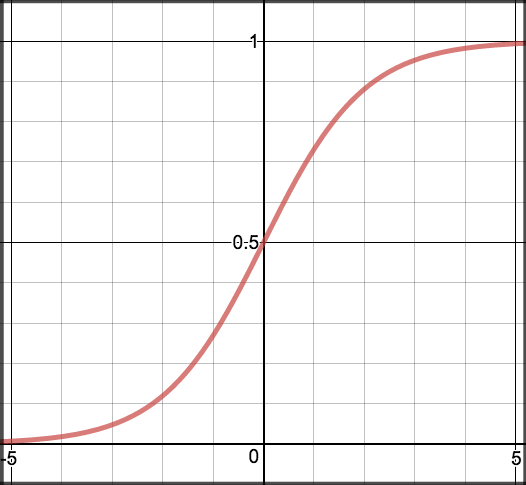

In [1]:
from IPython.display import Image
Image(filename="sigmoid.png", width="400", height="200")

The function for the sigmoid is as follows:  

\begin{equation}\tag{2.7}
P(class=1) = \frac{1} {1 + e^{-z}}
\end{equation}  

where $P(class=1)$ is the probability that our predicted value $z$ should be classified as 1. Again, $z$ is our predicted value, so it can thought of as  $h(\boldsymbol{\theta})$ or $\boldsymbol{\theta}^T\mathbf{x}'$. So we can write this sigmoid function another way:   
  
\begin{equation}\tag{2.8}
P(class=1) = \frac{1} {1 + e^{-\boldsymbol{\theta}^T\mathbf{x}'}}
\end{equation}
  
Equation 2.8 formed the basis for our sigmoid function that we wrote for our toy dataset in section 3 below.  
  
Once we have these probabilities, we need to pick a decision boundary between 0 and 1. One logical default value for that boundary is 0.5. So if the probability is greater than 0.5, classify the sample as 1, otherwise classify it as 0. In chart form, that would look like ([chart source](https://ml-cheatsheet.readthedocs.io/en/latest/logistic_regression.html)):  

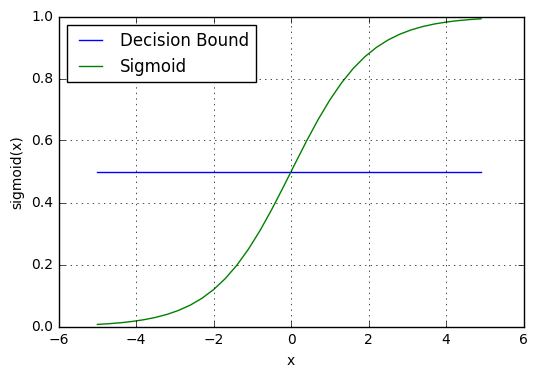

In [2]:
Image(filename="sigmoid_w_threshold.png", width="400", height="200")

And, in mathemathical form, it looks like:  
\begin{equation}\tag{2.9}
p \geq 0.5, class=1 \\
p < 0.5, class=0
\end{equation}

Equation 2.9 formed the basis for our decision_boundary function that we wrote in section 3 for our toy dataset.  
  
Like with linear regression, in order to parallelize the training of the linear model we can't do a closed-form solution but must treat it as an optimization problem with gradient descent. Fortunately, the Log Loss or Cross-Entropy Loss gives us a convex equation, allowing us to use gradient descent with the confidence of not hitting local minima.   
  
The Log Loss function is much like what it sounds: the negative of the log of the prediction value, though there is two versions depending on the actual label value.  
  
\begin{equation}\tag{2.10}
Cost(h_\theta(x'),y) = - log(h_\theta(x')), if y=1 \\
Cost(h_\theta(x'),y) = - log(1 - h_\theta(x')), if y=0
\end{equation}  
  
We can compile this into a single cost function taking advantage of the fact that we can zero out either side of the equation given $y$ being either 0 or 1 by multiplying one side of the equation by $y$ and another side by $(1-y)$:  

\begin{equation}\tag{2.11}
J(\theta) = - \frac{1}{m}\sum_{i=1}^{m}{[y_i log(h_\theta(x_i')) + (1 - y_i) log(1 - h_\theta(x_i'))]}
\end{equation}  

Using equation 2.6 from above ($h(\boldsymbol{\theta}) = \boldsymbol{\theta}^T\mathbf{x}'$), this can be rewritten as:  

\begin{equation}\tag{2.12}
J(\theta) = \frac{1}{m}\cdot(-\mathbf{y}\cdot\boldsymbol{\theta}^T\mathbf{x}' - (1 - \mathbf{y})\cdot log(1 - \boldsymbol{\theta}^T\mathbf{x}')
\end{equation}  

Equation 2.12 forms the basis of our spark job in the LogLoss function that we built for the toy dataset in section 3 below. 

For the gradient, we take the [first derivative of this cost function](https://ml-cheatsheet.readthedocs.io/en/latest/logistic_regression.html#gradient-descent), which winds up being:  
  
\begin{equation}\tag{2.13}
\nabla_\theta f = \mathbf{x}'\cdot(h(\boldsymbol{\theta}) - \mathbf{y}) \\
\nabla_\theta f = \mathbf{x}'\cdot(\frac{1}{1+e^{-\boldsymbol{\theta} \mathbf{x'}}} - \mathbf{y}) \\
\nabla_\theta f = \frac{x}{1+e^{-\boldsymbol{\theta} \mathbf{x'}}} -\mathbf{x}'\mathbf{y} \\ 
\end{equation}  

  
Equation 2.13 forms the basis of our spark job in the GDUpdate_wReg function that we built for the toy dataset in section 3 below.

## 3: EDA & Logistic Regression using RDDs

_Determine 2-3 relevant EDA tasks that will help you make decisions about how you implement the algorithm to be scalable. Discuss any challenges that you anticipate based on the EDA you perform_

In this section we will do the EDA on toy dataset first and note the findings. We will also repeat the EDA on full dataset. We will do the following tasks:

1) Calculate the correlations between features and with the label in order to see if we can eliminate some weak or duplicative features.  

2) Calculate the number of distinct values in each categorical variable so that we can throw out ones that have a high percentage of distinct values. These will be unlikely to have much correlation with the label (something we confirmed with a chi-squared test) and will explode the feature space if we try to one hot encode them.  

3) Perform a logistic regression using RDDs on the integer columns only to establish a baseline for more advanced models and ensure we understand the workings of the algorithm math outlined in Section 2. In Section 4, we will use Mlib with some feature engineering to try to beat the baseline from this EDA.  


In [1]:
# Load all the packages we need
import re
import ast
import time
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numbers

from pyspark.ml.feature import FeatureHasher
from pyspark.sql import SQLContext, Row
from pyspark.mllib.classification import LogisticRegressionWithSGD
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import SparseVector
from pyspark.sql.types import IntegerType
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import FeatureHasher
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import OneHotEncoderEstimator

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [5]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "fproj_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

In [287]:
# load the data into Spark RDD
projectRDD = sc.textFile('gs://w261-bucket-pav/notebooks/data/train.txt')

In [10]:
# A quick check on average CTR before we do any other steps
average_CTR = projectRDD.map(lambda x: int(x.split('\t')[0])).mean()
average_CTR

0.25622338372976045

In [288]:
projectRDD = projectRDD.map(lambda x: x.split('\t')).cache()

In [290]:
# Take a look at first record to ensure we read it correctly
projectRDD.take(1)

[['0',
  '1',
  '1',
  '5',
  '0',
  '1382',
  '4',
  '15',
  '2',
  '181',
  '1',
  '2',
  '',
  '2',
  '68fd1e64',
  '80e26c9b',
  'fb936136',
  '7b4723c4',
  '25c83c98',
  '7e0ccccf',
  'de7995b8',
  '1f89b562',
  'a73ee510',
  'a8cd5504',
  'b2cb9c98',
  '37c9c164',
  '2824a5f6',
  '1adce6ef',
  '8ba8b39a',
  '891b62e7',
  'e5ba7672',
  'f54016b9',
  '21ddcdc9',
  'b1252a9d',
  '07b5194c',
  '',
  '3a171ecb',
  'c5c50484',
  'e8b83407',
  '9727dd16']]

In [291]:
def parse(element):
    """
    Map record_csv_string --> (tuple,of,fields)
    """
    n_elements = len(element)
    fields = np.array(element)
    features,click = fields[1:], fields[0]
    return(features, click)

In [292]:
projectRDDCached = projectRDD.map(parse).cache()

In [293]:
# How many features do we have?
n_features = len(projectRDDCached.take(1)[0][0])
n_features

39

We have 39 features as expected. We know from the description that 13 of them are integers and 26 are categorical. Let us build our FIELDS (column names) now that reflects the kaggle names

In [294]:
integer_labels = ['I'+str(x) for x in range(1,14)]
print(len(integer_labels))
categor_labels = ['C'+str(x) for x in range(1,27)]
categor_labels.append('click')
FIELDS = integer_labels+categor_labels
print(len(FIELDS))

13
40


### EDA on toy dataset of 1000 records

In [295]:
# Take sample of 1000 trainRDD. Skip this step if you have pickled sample_df (further below)
sample = np.array(projectRDDCached.map(lambda x: np.append(x[0], [x[1]]))
                                .takeSample(False, 1000))
sample_df = pd.DataFrame(np.array(sample), columns = FIELDS)

In [296]:
sample_df.head(5)
#sample_df = pd.DataFrame(sample[0][0], columns = FIELDS)

,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,...,C18,C19,C20,C21,C22,C23,C24,C25,C26,click
0,,1,3,2,43993,,0,7,49,,...,e88ffc9d,8b067084,b1252a9d,90977168,ad3062eb,32c7478e,3fdb382b,cb079c2d,49d68486,1
1,8,-1,,,681,0,8,0,0,1,...,bd17c3da,712d530c,b1252a9d,80530232,,32c7478e,471f55fb,010f6491,cb1956a3,0
2,1,53,6,4,0,0,9,3,9,1,...,bd17c3da,5b9203c4,a458ea53,5a299f9e,,32c7478e,3ac1d485,010f6491,9d95018e,1
3,0,-1,,,1355,6,1,6,6,0,...,395856b0,21ddcdc9,b1252a9d,e5191f27,c9d4222a,3a171ecb,c23c2e19,001f3601,875d7cb9,0
4,,0,43,13,564734,,0,16,55,,...,7ef5affa,9a9aaf67,b1252a9d,1e4963f9,,32c7478e,3fdb382b,e8b83407,49d68486,0


In [297]:
# Pickle it so that others can use the same sample. This is just for comparison
sample_df.to_pickle("./sample_df.pkl")

In [ ]:
# Load the pickled data, if you got the sample_df from somewhere. Skip this step otherwise
sample_df = pd.read_pickle("./sample_df.pkl")

In [298]:
# Replace all empty strings with np.nan. Empty strings are not good for running correlation otherwise
sample_df = sample_df.replace(r'^\s*$', np.nan, regex=True)
sample_df.head(10)

,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,...,C18,C19,C20,C21,C22,C23,C24,C25,C26,click
0,NaN,1,3,2,43993,NaN,0,7,49,NaN,...,e88ffc9d,8b067084,b1252a9d,90977168,ad3062eb,32c7478e,3fdb382b,cb079c2d,49d68486,1
1,8,-1,NaN,NaN,681,0,8,0,0,1,...,bd17c3da,712d530c,b1252a9d,80530232,NaN,32c7478e,471f55fb,010f6491,cb1956a3,0
2,1,53,6,4,0,0,9,3,9,1,...,bd17c3da,5b9203c4,a458ea53,5a299f9e,NaN,32c7478e,3ac1d485,010f6491,9d95018e,1
3,0,-1,NaN,NaN,1355,6,1,6,6,0,...,395856b0,21ddcdc9,b1252a9d,e5191f27,c9d4222a,3a171ecb,c23c2e19,001f3601,875d7cb9,0
4,NaN,0,43,13,564734,NaN,0,16,55,NaN,...,7ef5affa,9a9aaf67,b1252a9d,1e4963f9,NaN,32c7478e,3fdb382b,e8b83407,49d68486,0
5,NaN,4,NaN,3,89868,NaN,0,3,3,NaN,...,5ce4203e,NaN,NaN,a466b525,NaN,32c7478e,9b18ad04,NaN,NaN,0
6,NaN,19,10,8,1892,16,15,8,17,NaN,...,29b0e3e5,NaN,NaN,2b81e06c,ad3062eb,55dd3565,2f647dfe,NaN,NaN,1
7,NaN,1,1,4,5355,43,30,0,42,NaN,...,c21c3e4c,5d097c5a,a458ea53,611af665,NaN,c7dc6720,5d3ae26f,9b3e8820,b9772eb5,1
8,NaN,38,31,18,23588,236,1,18,126,NaN,...,a863ac26,NaN,NaN,67aad1f6,NaN,93bad2c0,8ec48ff8,NaN,NaN,0
9,NaN,17,15,14,4068,62,130,16,71,NaN,...,642f2610,21ddcdc9,b1252a9d,2421b611,ad3062eb,423fab69,45ab94c8,2bf691b1,c84c4aec,0


In [299]:
# Check for number of NULL values in our dataframe.
sample_df[FIELDS[0:13]].isnull().sum()

I1     458
I2       0
I3     204
I4     221
I5      27
I6     229
I7      41
I8       0
I9      41
I10    458
I11     41
I12    757
I13    221
dtype: int64

**Analysis of results:**
I12, I10, I1 has many null values. We will later  validate these findings on full dataset and see if it matches

In [300]:
sample_df[FIELDS[0:13]] = sample_df[FIELDS[0:13]].astype(float)
sample_df.click = sample_df.click.astype(float)

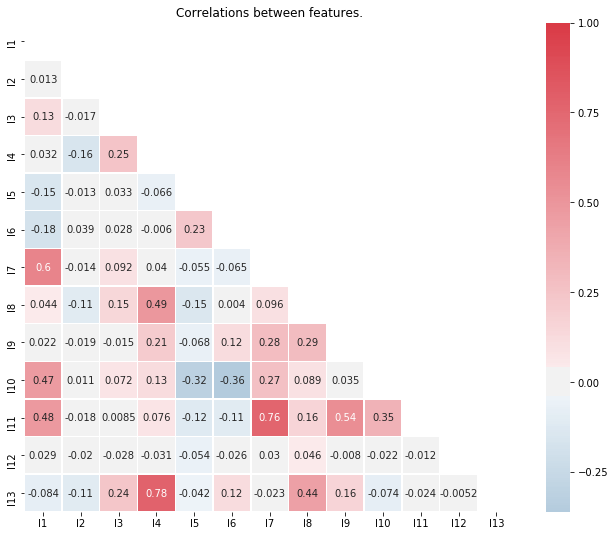

In [301]:
# Correlation between the dependent variables
corr = sample_df[FIELDS[0:13]].corr()
fig,ax = plt.subplots(figsize=(11, 9))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True,center=0, linewidths=.5)
plt.title("Correlations between features.")
plt.show()

** Analysis of results: ** I4 & I13, I8 & I13, I7 & I11, I1 & I7 are highly correlated. Since I13 appears twice and correlated with I4 and I8, we can possibly eliminate I13.

In [302]:
# Check correlation with target variable and other integer features
sample_df.drop(FIELDS[13:], axis=1).apply(lambda x: x.corr(sample_df.click))

I1     0.102154
I2     0.064720
I3    -0.048040
I4    -0.032795
I5    -0.100168
I6    -0.117093
I7     0.122474
I8     0.000551
I9     0.107756
I10    0.207656
I11    0.213373
I12    0.158306
I13   -0.111183
dtype: float64

#### Variables that are least correlated with outcome value is I8

Let us now find the number of unique values in each categorical variable

In [303]:
def n_unique(x):
    """ Counts number of unique values"""
    #If an entry is blank, add them as unique
    total_na = x.isna().sum()
    return x.nunique() + total_na


In [304]:
sample_df[FIELDS[13:n_features]].apply(n_unique,axis=0)

C1      58
C2     195
C3     780
C4     657
C5      24
C6     130
C7     721
C8      36
C9       2
C10    611
C11    587
C12    758
C13    536
C14     18
C15    571
C16    723
C17      9
C18    393
C19    571
C20    445
C21    747
C22    760
C23     11
C24    495
C25    469
C26    770
dtype: int64

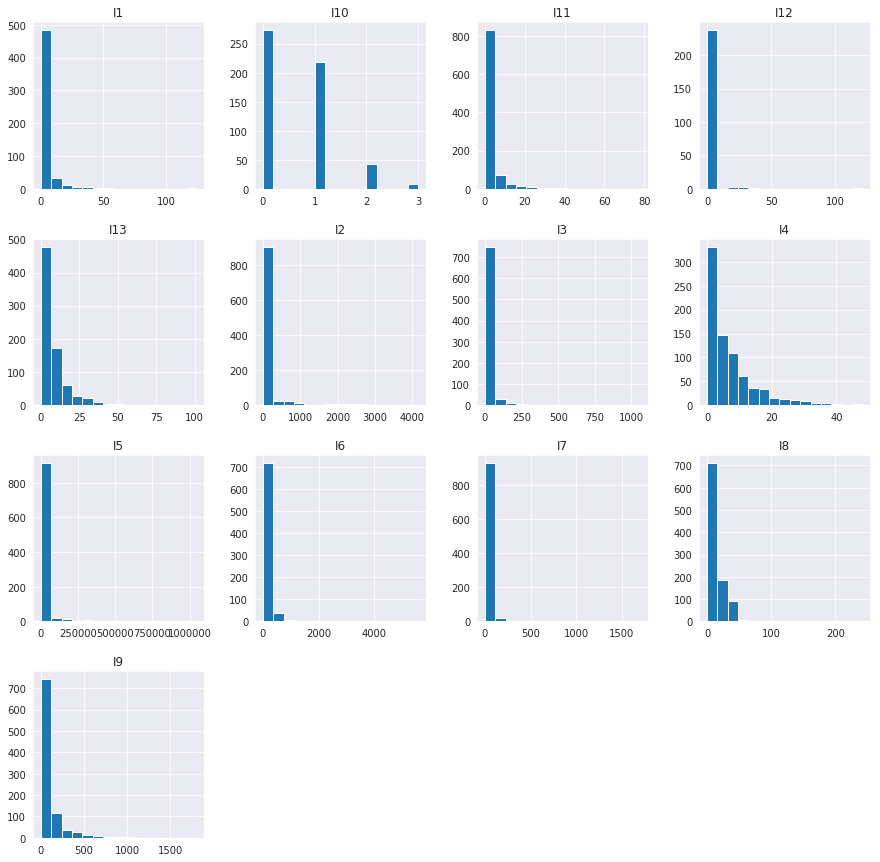

In [345]:
sample_df[FIELDS[0:13]].hist(figsize=(15,15), bins=15)
plt.show()

In [346]:
sample_df['I5'].describe()

count    9.730000e+02
mean     2.230645e+04
std      7.888478e+04
min      0.000000e+00
25%      6.070000e+02
50%      2.895000e+03
75%      1.016300e+04
max      1.044564e+06
Name: I5, dtype: float64

Variable I5 seem to have major outliers looking at its range

### EDA on Full Dataset

In [307]:
## Distinct values per column on full dataset
def emit_col_val(line):
    features = line[0]
    N = len(features)
    for i in range(13,N):
        yield(i,features[i])

def count_values(line):
    """ Return word count"""
    feature,cat_values = line
    yield (feature,len(cat_values.split()))

catFeatRDD = projectRDDCached.flatMap(emit_col_val)\
                    .distinct()\
                    .reduceByKey(lambda x,y : x+' '+y) \
                    .flatMap(count_values).cache()



In [308]:
catFeat = catFeatRDD.collect()

In [357]:
#catFeat

In [104]:
for i in range(len(catFeat)):
    print('{}: {}'.format(FIELDS[catFeat[i][0]],catFeat[i][1]))

C1: 1460
C2: 579
C3: 8380405
C4: 1884751
C5: 305
C6: 23
C7: 12493
C8: 633
C9: 3
C10: 89036
C11: 5657
C12: 6951577
C13: 3194
C14: 27
C15: 14752
C16: 4590483
C17: 10
C18: 5590
C19: 2166
C20: 3
C21: 5894198
C22: 17
C23: 15
C24: 258633
C25: 104
C26: 133146


In [319]:
categor_labels.pop(26)

In [356]:
keys = categor_labels
UniqueCounts_dict = {key: 0 for key in keys}
count = 1
for val in catFeat:
    c = 'C'+str(count)
    m = val[1]   
    UniqueCounts_dict[c] = m/1000000
    count+=1

UniqueCounts_dict

{'C1': 0.00146,
 'C2': 0.000583,
 'C3': 10.131226,
 'C4': 2.202607,
 'C5': 0.000305,
 'C6': 2.3e-05,
 'C7': 0.012517,
 'C8': 0.000633,
 'C9': 3e-06,
 'C10': 0.093145,
 'C11': 0.005683,
 'C12': 8.351592,
 'C13': 0.003194,
 'C14': 2.7e-05,
 'C15': 0.014992,
 'C16': 5.461305,
 'C17': 1e-05,
 'C18': 0.005652,
 'C19': 0.002172,
 'C20': 3e-06,
 'C21': 7.046546,
 'C22': 1.7e-05,
 'C23': 1.5e-05,
 'C24': 0.28618,
 'C25': 0.000104,
 'C26': 0.142571}

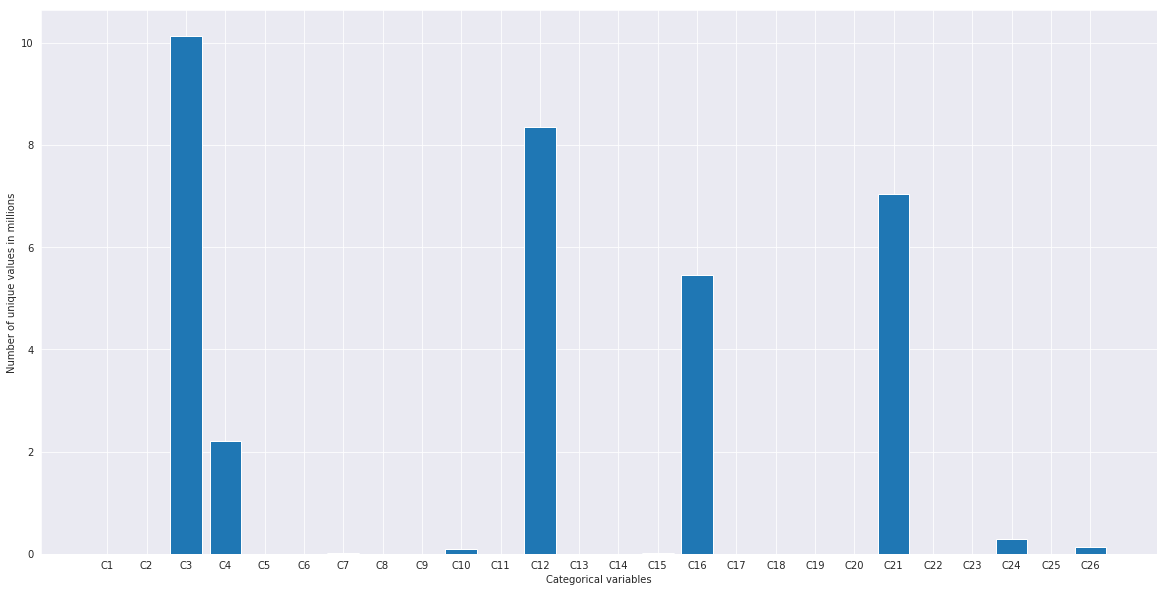

In [342]:
sns.set_style('darkgrid')
keys = UniqueCounts_dict.keys()
vals = UniqueCounts_dict.values()
plt.figure(figsize=(20,10))
plt.bar(keys, vals, label="Count distribution")

#plt.ylim(0,1)
plt.ylabel ('Number of unique values in millions')
plt.xlabel ('Categorical variables')
plt.xticks(list(keys))
plt.show()

In [ ]:
# try doing chi-squared test for categorical features and the label
# relied on code from here: https://codereview.stackexchange.com/questions/96761/chi-square-independence-test-for-two-pandas-df-columns
# the code below ran with a pandas dataframe from an old notebook

factorizedPDF = samplePDF[label_and_numeric]
for colname in categorical_features:
    factorizedPDF[colname] = pd.factorize(samplePDF[colname])[0]
    
import scipy.stats as scs

def categories(series):
    return range(int(series.min()), int(series.max()) + 1)

def chi_square_of_df_cols(df, col1, col2):
    df_col1, df_col2 = df[col1], df[col2]

    result = [[sum((df_col1 == cat1) & (df_col2 == cat2))
               for cat2 in categories(df_col2)]
              for cat1 in categories(df_col1)]
    
    # can't have cells in contigency table <5, so tossing out small categories
    # valid if just trying to get a rough idea of associations? hopefully...
    new_cont_table = []
    for pair in result:
        if (pair[0] >= 5 and pair[1] >= 5):
            new_cont_table.append(pair)
    
    if (new_cont_table == []): 
        return None
    else:
        return scs.chi2_contingency(new_cont_table)

print("Chi_square test on each categorical column with label\n")
for colname in categorical_features:
    if chi_square_of_df_cols(factorizedPDF, colname, 'label') != None:
        p_val = chi_square_of_df_cols(factorizedPDF, colname, 'label')[1]
        print(colname, "p-value: ", p_val)
    else:
        print(colname, "p-value: None")


In [ ]:
Chi_square test on each categorical column with label

C1 p-value:  0.21082798547288253
C2 p-value:  0.6435562286680369
C3 p-value:  1.0
C4 p-value:  0.012948939934941228
C5 p-value:  0.8535936414496317
C6 p-value:  0.049581973659291234
C7 p-value:  0.797861519994188
C8 p-value:  0.6135336372023791
C9 p-value:  7.50591017192037e-05
C10 p-value:  1.0
C11 p-value:  0.7938565664416881
C12 p-value:  1.0
C13 p-value:  0.6702820959999762
C14 p-value:  0.0004643180576810328
C15 p-value: None
C16 p-value:  0.010838360359114419
C17 p-value:  6.215519829380432e-06
C18 p-value:  0.36916060790189564
C19 p-value:  0.4073140424351105
C20 p-value:  0.3279960391349751
C21 p-value:  0.010838360359114419
C22 p-value:  0.3632684079519511
C23 p-value:  0.2132366139150885
C24 p-value:  0.7881904129396066
C25 p-value:  0.3848364145236987
C26 p-value:  0.4419905004244705

**Analysis of results:**
The most valuable categorical variables seem to be C6, C9, C14, C17, C20, C22, C23 as they all have fewer than 100 unique values. This is important because if we tried to include all the categorical variables through one hot encoding, we would wind up creating 10s of millions of features. This smaller list of categorical variables would result in less than 1,000 new features. We also ran a chi-squared test on the on each categorical feature with the labels and found a lot of overlap: C4, C6, C9, C14, C16, C17, and C21 all showed significant correlation, suggesting that choosing the columns with the fewest distinct values for one hot encoding would be both practical and meaningful.  

In [309]:
# How many NULL values are there in each integer variable?

def emit_int_feat(line):
    features = line[0]
    N = len(features)
    for i in range(13):
        column = 'I'+str(i+1)
        if features[i]=="":
            yield(column,1)

NullCountRDD = projectRDDCached.flatMap(emit_int_feat)\
                    .reduceByKey(lambda x,y : x+y).cache()

In [349]:
NullCounts = NullCountRDD.collect()
NullCounts

[('I10', 20793556),
 ('I7', 1982866),
 ('I13', 9937369),
 ('I1', 20793556),
 ('I4', 9937369),
 ('I12', 35071652),
 ('I3', 9839447),
 ('I11', 1982866),
 ('I6', 10252328),
 ('I5', 1183117),
 ('I9', 1982866),
 ('I8', 22773)]

In [359]:
keys = integer_labels
NullCounts_dict = {key: 0 for key in keys}
count = 1
for val in NullCounts:
    c = val[0]
    m = val[1]
    #c_num = int(c[1:])
    NullCounts_dict[c] = m/1000000
    count +=1
NullCounts_dict 

{'I1': 20.793556,
 'I2': 0,
 'I3': 9.839447,
 'I4': 9.937369,
 'I5': 1.183117,
 'I6': 10.252328,
 'I7': 1.982866,
 'I8': 0.022773,
 'I9': 1.982866,
 'I10': 20.793556,
 'I11': 1.982866,
 'I12': 35.071652,
 'I13': 9.937369}

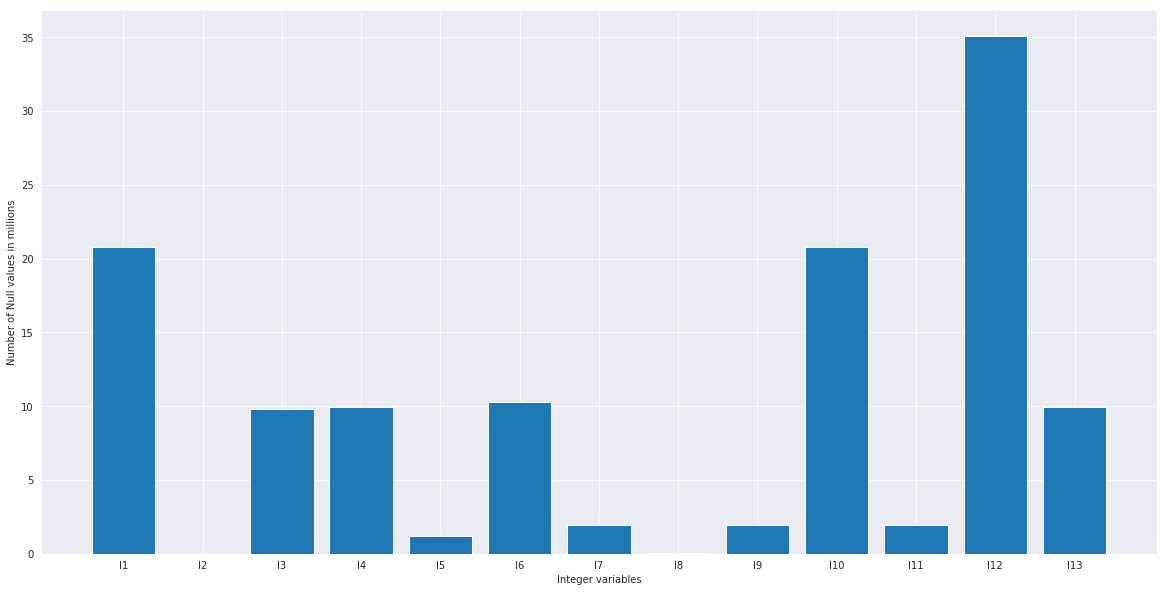

In [360]:
#sns.set_style('darkgrid')
keys = NullCounts_dict.keys()
vals = NullCounts_dict.values()
plt.figure(figsize=(20,10))
plt.bar(keys, vals, label="Count distribution")

#plt.ylim(0,1)
plt.ylabel ('Number of Null values in millions')
plt.xlabel ('Integer variables')
plt.xticks(list(keys))
plt.show()

**Analysis of results:** I2 has no null values. But rest of them have a lot. I12 has 35 Million null values (77%), I1 and I10 has ~21Million (47%), I3,I4,I6 and I13 have close to 10Million null values (22%). Considering the amount of missing values in I12, it appears that I12 has very little use.

#### Null values 

In [361]:
count = projectRDDCached.count()
keys = list(range(1,14))
NonNullCounts_dict = {key: count for key in keys}
for val in NullCounts:
    c = val[0]
    m = val[1]
    c_num = int(c[1:])
    NonNullCounts_dict[c_num] = count-m
NonNullCounts_dict

{1: 25047061,
 2: 45840617,
 3: 36001170,
 4: 35903248,
 5: 44657500,
 6: 35588289,
 7: 43857751,
 8: 45817844,
 9: 43857751,
 10: 25047061,
 11: 43857751,
 12: 10768965,
 13: 35903248}

In [362]:
# Broadcast the non null counts as we need it to calculate the mean
NonNullCounts_bc = sc.broadcast(NonNullCounts_dict)

In [364]:
#NonNullCounts_bc.value

In [437]:
def int_features(line):
    """ Extracts Integer Features"""
    features = line[0]
    label = int(line[1])
    new_arr = np.array(features[0:13])
    yield((new_arr,label))

IntFeatRDD = projectRDDCached.flatMap(int_features).cache()

In [439]:
IntFeatRDD.take(4)

[(array(['1', '1', '5', '0', '1382', '4', '15', '2', '181', '1', '2', '',
         '2'], dtype='<U8'), 0),
 (array(['2', '0', '44', '1', '102', '8', '2', '2', '4', '1', '1', '', '4'],
        dtype='<U8'), 0),
 (array(['2', '0', '1', '14', '767', '89', '4', '2', '245', '1', '3', '3',
         '45'], dtype='<U8'), 0),
 (array(['', '893', '', '', '4392', '', '0', '0', '0', '', '0', '', ''],
        dtype='<U8'), 0)]

In [368]:
count

45840617

#### Decision on how to handle nulls
We tried a few options:  

1) Simply delete rows of data that any nulls. However, we were not comfortable with this approach as the data is sparse and it resulted in approximately 90% of the integer-only data being removed.  

2) Create missing value dummy variables that recorded if there was data or not in each of the original features. Then we replaced the null values with zeros. We didn't find the missing data features to be very useful once we passed through an L1 Regularization, and we also came to worry about columns where so many zeros could change the overall structure of the data.  

3) We opted ultimately to simply replace the null values with mean values.  

In [414]:
# It could be better to replace the null values with their mean in the integer variables. Calculate mean per column
def emit_int_features(line):
    features = line[0]
    for i in range(len(features)):
        column = i+1
        r1 = re.match("\d",features[i])
        if r1:
            yield(column,float(features[i]))
def emit_mean(x):
    """ We had to write this function because we only want the mean of non NULL values"""
    column = int(x[0])
    total = x[1]
    #mean_val = total/36668665
    mean_val = total/NonNullCounts_bc.value[column]
    yield(column,mean_val)

mean_values = IntFeatRDD.flatMap(emit_int_features)\
                    .reduceByKey(lambda x,y : x+y)\
                    .flatMap(emit_mean).collect()

In [415]:
mean_values

[(1, 3.5024133170754044),
 (2, 105.95261651910138),
 (3, 26.913041020611274),
 (4, 7.322680248873305),
 (5, 18538.991664871523),
 (6, 116.06185085211598),
 (7, 16.333130032135028),
 (8, 12.517042137556713),
 (9, 106.1098234380509),
 (10, 0.6175294977722137),
 (11, 2.7328343170173044),
 (12, 0.9910356287721244),
 (13, 8.217461161174054)]

In [371]:
mean_dict = dict()
for val in mean_values:
    c = val[0]
    m = val[1]
    mean_dict[c] = m

#mean_dict    

In [372]:
# Broadcast the mean dictionary. We need it to replace null values later
mean_dict_bc = sc.broadcast(mean_dict)


In [429]:
mean_dict_bc.value

{1: 3.5024133170754044,
 2: 105.84841979766546,
 3: 26.913041020611274,
 4: 7.322680248873305,
 5: 18538.991664871523,
 6: 116.06185085211598,
 7: 16.333130032135028,
 8: 12.517042137556713,
 9: 106.1098234380509,
 10: 0.6175294977722137,
 11: 2.7328343170173044,
 12: 0.9910356287721244,
 13: 8.217461161174054}

### Data preparation
Keep only the categorical variables that appeared useful from the EDA and replace all integer nulls with mean values. 

In [373]:
def remove_categorical(x):
    """ Removes unwanted categorical variables"""
    features = x[0]
    label = x[1]
    # We are interested in C6,C9, C14, C17, C20, C22, C23
    # These are at index 18,21,26,29,32,34,35
    c_index_list = [18,21,26,29,32,34,35]
    new_arr = np.array(features[0:13],dtype=str)
    for index in c_index_list:
        new_arr = np.append(new_arr,features[index])
    yield((new_arr,label))

projectRDD_truncated = projectRDDCached.flatMap(remove_categorical).cache()

In [374]:
projectRDD_truncated.take(1)

[(array(['1', '1', '5', '0', '1382', '4', '15', '2', '181', '1', '2', '',
         '2', '7e0ccccf', 'a73ee510', '1adce6ef', 'e5ba7672', 'b1252a9d',
         '', '3a171ecb'], dtype='<U8'), '0')]

In [442]:
# Replace all blanks in projectRDD_truncated integer values with their means

def replace_int_null(x):
    features = x[0]
    label = int(x[1])
    for i in range(13):
        #r1 = re.match("\D",features[i])
        if features[i] == "":
            features[i] = mean_dict_bc.value[i+1]
        else:
            features[i] = features[i]
    features = features.astype(float)
    yield((features,label))

def replace_int_null_noInt(x):
    features = x[0]
    label = int(x[1])
    for i in range(13):
        #r1 = re.match("\D",features[i])
        if features[i] == "":
            features[i] = float(mean_dict_bc.value[i+1])
        else:
            features[i] = float(features[i])
    yield((features,label))
    
def replace_char_null(x):
    features = x[0]
    label = int(x[1])
    for i in range(13,len(features)):
        if features[i]=="":
            features[i] = 'AAAA'
    yield((features,label))
    

In [376]:
projectRDD_truncated = projectRDD_truncated.flatMap(replace_int_null_noInt)\
                                    .flatMap(replace_char_null).cache()
projectRDD_truncated.take(1)

[(array(['1.0', '1.0', '5.0', '0.0', '1382.0', '4.0', '15.0', '2.0',
         '181.0', '1.0', '2.0', '0.991035', '2.0', '7e0ccccf', 'a73ee510',
         '1adce6ef', 'e5ba7672', 'b1252a9d', 'AAAA', '3a171ecb'],
        dtype='<U8'), 0)]

In [443]:
IntFeatRDD = IntFeatRDD.flatMap(replace_int_null).cache()
IntFeatRDD.take(1)

[(array([1.00000e+00, 1.00000e+00, 5.00000e+00, 0.00000e+00, 1.38200e+03,
         4.00000e+00, 1.50000e+01, 2.00000e+00, 1.81000e+02, 1.00000e+00,
         2.00000e+00, 9.91035e-01, 2.00000e+00]), 0)]

### Logistic Regression with RDDs using integer variables

We will now apply logistic regression on just the integer RDD to give us a baseline. We did this step using RDDs so that we were confident we understood the underlying math and operation of the algorithm. Later, we used the MLlib libraries and more complicated feature engineering to try to improve on the baseline. 

In [444]:
def normalize(dataRDD):
    """
    Scale and center data round mean of each feature.
    Args:
        dataRDD - records are tuples of (features_array, y)
    Returns:
        normedRDD - records are tuples of (features_array, y)
    """
    featureMeans = dataRDD.map(lambda x: x[0]).mean()
    featureStdev = np.sqrt(dataRDD.map(lambda x: x[0]).variance())
    normedRDD = dataRDD.map(lambda x: (np.divide((x[0] - featureMeans), featureStdev), x[1]))        
    return normedRDD

In [445]:
normedRDD = normalize(IntFeatRDD).cache()

In [446]:
normedRDD.take(1)

[(array([-3.59034938e-01, -2.97369652e-01, -6.21321553e-02, -9.40979069e-01,
         -2.50491780e-01, -3.32447098e-01, -2.06349467e-02, -6.30339047e-01,
          3.47572771e-01,  7.56409286e-01, -1.44106014e-01, -5.44431921e-08,
         -4.33347858e-01]), 0)]

In [447]:
toyIntRDD = sc.parallelize(normedRDD.takeSample(False,500))
toyTrainRDD, toyTestRDD = toyIntRDD.randomSplit([0.5,0.5])


In [465]:
toyTrainRDD.saveAsTextFile('gs://w261-bucket-pav/notebooks/data/toyTrain.txt')
toyTestRDD.saveAsTextFile('gs://w261-bucket-pav/notebooks/data/toyTest.txt')

In [500]:
def LogLoss(dataRDD, W):
    """
    Compute loss using log loss or cross entropy formula.
    Args:
        dataRDD - each record is a tuple of (features_array, y)
        W       - (array) model coefficients with bias at index 0
    Adapted from sources:
    * Homework 4 code for W261
    * https://ml-cheatsheet.readthedocs.io/en/latest/logistic_regression.html
    * https://www.internalpointers.com/post/cost-function-logistic-regression
    """
    
    epsilon = 10e-12
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))

    loss = augmentedData.map(lambda x: (-np.dot(x[1],np.log(1 / (1 + np.exp(-np.dot(W, x[0])))+epsilon)) -\
                                        np.dot((1-x[1]),np.log(1- (1 / (1 + np.exp(-np.dot(W, x[0]))))+epsilon)), 1)) \
                        .reduce(lambda x,y:(x[0]+y[0], x[1]+y[1]))

    loss = float(loss[0])/loss[1]
    
    return loss

In [501]:
def GDUpdate_wReg(dataRDD, W, N, learningRate = 0.1, regType = None, regParam = 0.1):
    """
    Perform one gradient descent step/update with ridge or lasso regularization.
    Args:
        dataRDD - tuple of (features_array, y)
        W       - (array) model coefficients with bias at index 0
        learningRate - (float) defaults to 0.1
        regType - (str) 'ridge' or 'lasso', defaults to None
        regParam - (float) regularization term coefficient
    Returns:
        model   - (array) updated coefficients, bias still at index 0
    Adapted from sources:
    * Homework 4 code from W261
    * Notebook cited by Jimi in asynch: https://nbviewer.jupyter.org/urls/dl.dropbox.com/s/r20ff7q0yni5kiu/LogisticRegression-Spark-Notebook.ipynb
    """
    
    # augmented data
    # this puts a 1.0 in front of x's to pass thru bias term
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1])) 
    
    new_model = None
    
    # calculate the gradient
    
    gradient = augmentedData.map(lambda x: (x[0] / (1 + np.exp(-np.dot(W, x[0])))) - np.dot(x[1], np.array(x[0])))\
                   .reduce(lambda x, y: x + y)
    
    #gradient = augmentedData.map(lambda x: (1 / (1 + np.exp(-x[1]*np.dot(W, x[0])))-1) * x[1] * np.array(x[0]))\
    #                .reduce(lambda x, y: x + y)
    if regType == "ridge":
        wReg = W * 1
        wReg = np.append([0], wReg[1:]) # remove the bias term ahead of regularization        
    elif regType == "lasso":
        wReg = W * 1
        wReg = np.append([0], wReg[1:]) # remove the bias term ahead of regularization
        wReg = (wReg>0).astype(int) * 2-1
    else:
        wReg = np.zeros(W.shape[0])
    gradient = gradient + regParam * wReg  #gradient:  GD of Squared Error+ GD of regularized term 
    new_model = W - learningRate * gradient / N

    return new_model

In [502]:
def GradientDescent_wReg(trainRDD, testRDD, wInit, nSteps = 20, learningRate = 0.1,
                         regType = None, regParam = 0.1, verbose = True):
    """
    Perform nSteps iterations of regularized gradient descent and 
    track loss on a test and train set. Return lists of
    test/train loss and the models themselves.
    Adapted from sources:
    * Homework 4 code from W261
    * Notebook cited by Jimi in asynch: https://nbviewer.jupyter.org/urls/dl.dropbox.com/s/r20ff7q0yni5kiu/LogisticRegression-Spark-Notebook.ipynb    
    """
    # initialize lists to track model performance
    train_history, test_history, model_history = [], [], []
    
    # calculate N here so you don't have to do it in the for looped function call
    N = trainRDD.count()

    # make a starter set of weights if none provided
    featureLen = len(trainRDD.take(1)[0][0])
    if wInit is None:
        w = np.random.normal(size=featureLen+1) # w should be broadcasted if it is large
    else:
        w = wInit
    model = w
    
    # perform nSteps updates & compute test and train loss after each
    for idx in range(nSteps):  
   
        # update the model
        model = GDUpdate_wReg(trainRDD, model, N, learningRate, regType, regParam)
        
        # keep track of test/train loss for plotting
        training_loss = LogLoss(trainRDD, model)
        test_loss = LogLoss(testRDD, model)
        train_history.append(training_loss)
        test_history.append(test_loss)
        model_history.append(model)
        
        # console output if desired
        if verbose:
            print("----------")
            print(f"STEP: {idx+1}")
            print(f"training loss: {training_loss}")
            print(f"test loss: {test_loss}")
            print(f"Model: {[round(w,3) for w in model]}")
    return train_history, test_history, model_history

In [491]:
wInit = np.array([0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,0.0])
start = time.time()
lasso_results = GradientDescent_wReg(toyTrainRDD, toyTestRDD, wInit, nSteps = 20,
                                     regType='lasso', regParam = 0.1)
print(f"\n... trained {len(lasso_results[2])} 2 iterations in {time.time() - start} seconds")

----------
STEP: 1
training loss: 0.6864239875982796
test loss: 0.6867361003298752
Model: [-0.023, 0.004, -0.001, 0.0, -0.005, -0.002, -0.001, 0.004, -0.0, 0.003, 0.002, 0.005, 0.008, -0.002]
----------
STEP: 2
training loss: 0.6800638129719868
test loss: 0.6806732090419743
Model: [-0.045, 0.007, -0.001, 0.0, -0.01, -0.004, -0.001, 0.008, -0.0, 0.005, 0.004, 0.009, 0.015, -0.003]
----------
STEP: 3
training loss: 0.6740277350984865
test loss: 0.6749235936865
Model: [-0.067, 0.01, -0.002, 0.0, -0.014, -0.007, -0.002, 0.011, -0.0, 0.007, 0.006, 0.013, 0.023, -0.004]
----------
STEP: 4
training loss: 0.6682974313881324
test loss: 0.6694700546388954
Model: [-0.089, 0.013, -0.002, 0.001, -0.019, -0.009, -0.003, 0.015, -0.0, 0.009, 0.008, 0.016, 0.03, -0.006]
----------
STEP: 5
training loss: 0.6628556342071049
test loss: 0.6642963265557864
Model: [-0.109, 0.016, -0.003, 0.001, -0.023, -0.011, -0.003, 0.018, -0.0, 0.011, 0.01, 0.02, 0.037, -0.007]
----------
STEP: 6
training loss: 0.65768608

In [503]:
featureLen = len(normedRDD.take(1)[0][0])
#wInit = np.random.normal(size=featureLen)
wInit = np.array([0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,0.0])
trainRDD, testRDD = normedRDD.randomSplit([0.8,0.2], seed = 2019)
start = time.time()
lasso_results = GradientDescent_wReg(trainRDD, testRDD,wInit, nSteps = 50,
                                     regType='lasso', regParam = 0.1)
print(f"\n... trained {len(lasso_results[2])} 50 iterations in {time.time() - start} seconds")

----------
STEP: 1
training loss: 0.6858037036664725
test loss: 0.6857982599351395
Model: [-0.024, 0.003, 0.002, 0.001, -0.002, -0.003, -0.003, 0.004, -0.001, 0.001, 0.006, 0.007, 0.002, -0.003]
----------
STEP: 2
training loss: 0.6788855840922129
test loss: 0.6788743482565835
Model: [-0.048, 0.006, 0.004, 0.001, -0.004, -0.007, -0.007, 0.007, -0.002, 0.002, 0.012, 0.013, 0.004, -0.006]
----------
STEP: 3
training loss: 0.6723619560164081
test loss: 0.672344911742798
Model: [-0.071, 0.009, 0.006, 0.002, -0.006, -0.01, -0.01, 0.01, -0.003, 0.002, 0.017, 0.019, 0.006, -0.009]
----------
STEP: 4
training loss: 0.6662052421608898
test loss: 0.6661824341058157
Model: [-0.094, 0.011, 0.008, 0.002, -0.008, -0.013, -0.013, 0.013, -0.005, 0.003, 0.022, 0.025, 0.007, -0.012]
----------
STEP: 5
training loss: 0.6603905605977155
test loss: 0.6603620520804635
Model: [-0.116, 0.013, 0.01, 0.002, -0.01, -0.016, -0.016, 0.015, -0.006, 0.003, 0.027, 0.031, 0.009, -0.014]
----------
STEP: 6
training los

----------
STEP: 44
training loss: 0.5654159003082031
test loss: 0.5652436564829438
Model: [-0.665, 0.039, 0.049, 0.016, -0.045, -0.093, -0.093, 0.04, -0.039, 0.007, 0.129, 0.145, 0.048, -0.083]
----------
STEP: 45
training loss: 0.5645733784946071
test loss: 0.5643989799897905
Model: [-0.673, 0.038, 0.05, 0.017, -0.046, -0.095, -0.094, 0.04, -0.04, 0.007, 0.13, 0.147, 0.048, -0.085]
----------
STEP: 46
training loss: 0.563765217873196
test loss: 0.5635887146050289
Model: [-0.682, 0.038, 0.05, 0.017, -0.046, -0.096, -0.096, 0.04, -0.041, 0.007, 0.131, 0.148, 0.049, -0.086]
----------
STEP: 47
training loss: 0.5629898101490745
test loss: 0.5628112507405253
Model: [-0.69, 0.038, 0.051, 0.017, -0.047, -0.098, -0.097, 0.04, -0.041, 0.007, 0.133, 0.15, 0.05, -0.087]
----------
STEP: 48
training loss: 0.5622456312099323
test loss: 0.5620650630470441
Model: [-0.698, 0.038, 0.051, 0.017, -0.047, -0.099, -0.098, 0.039, -0.042, 0.007, 0.134, 0.151, 0.05, -0.088]
----------
STEP: 49
training loss

In [504]:
# make error curve plots that show declining loss as walk down the gradient
# from HW4 code

def plotErrorCurves(trainLoss, testLoss, title = None):
    """
    Helper function for plotting.
    Args: trainLoss (list of log loss) , testLoss (list of log loss)
    """
    fig, ax = plt.subplots(1,1,figsize = (16,8))
    x = list(range(len(trainLoss)))[1:]
    ax.plot(x, trainLoss[1:], 'k--', label='Training Loss')
    ax.plot(x, testLoss[1:], 'r--', label='Test Loss')
    ax.legend(loc='upper right', fontsize='x-large')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Log Loss')
    if title:
        plt.title(title)
    plt.show()

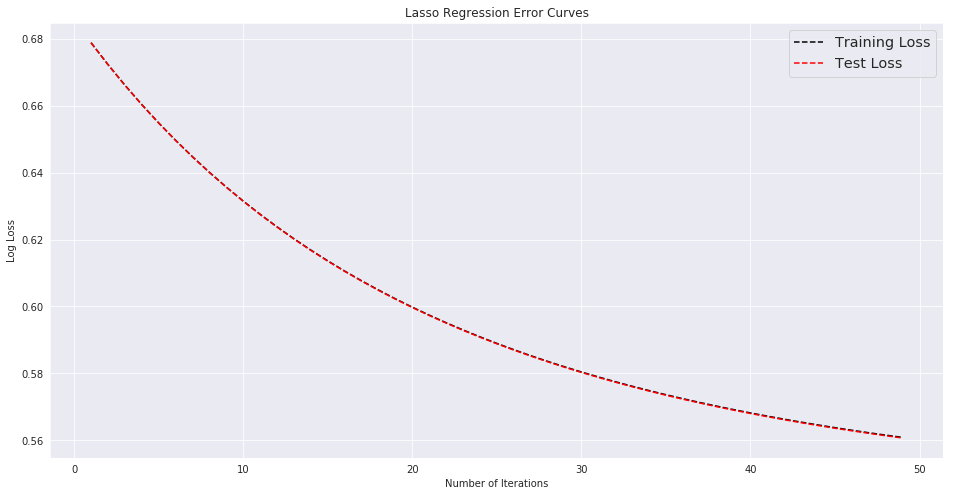

In [505]:
trainLoss, testLoss, models = lasso_results
lasso_models = np.array(models)
#np.savetxt('gs://w261-bucket-pav/notebooks/lasso_models.csv', np.array(models), delimiter=',')
#np.savetxt('gs://w261-bucket-pav/notebooks/lasso_loss.csv', np.array([trainLoss, testLoss]), delimiter=',')
plotErrorCurves(trainLoss, testLoss, title = 'Lasso Regression Error Curves' )

In [506]:
#lasso_models = np.loadtxt(PWD + '/data/lasso_models.csv', dtype=float, delimiter=',')
best_lasso = lasso_models[-1,:]

In [507]:
best_lasso

array([-0.71342124,  0.03769524,  0.0520761 ,  0.01780462, -0.04761511,
       -0.10154564, -0.10101689,  0.03858296, -0.04317731,  0.00676181,
        0.1361737 ,  0.15415663,  0.05135565, -0.09071185])

In [508]:
# Now that we have the schema corrected, create some feature grouping lists for easy data manipulation
numeric_features = ["I1", "I2", "I3", "I4", "I5", "I6", "I7", "I8", "I9", "I10", "I11", "I12", "I13"]
categorical_features = ["C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "C9", "C10", "C11", "C12",\
                        "C13", "C14", "C15", "C16", "C17", "C18", "C19", "C20", "C21", "C22", "C23",\
                       "C24", "C25", "C26"]
label_and_numeric = ["label"] + numeric_features

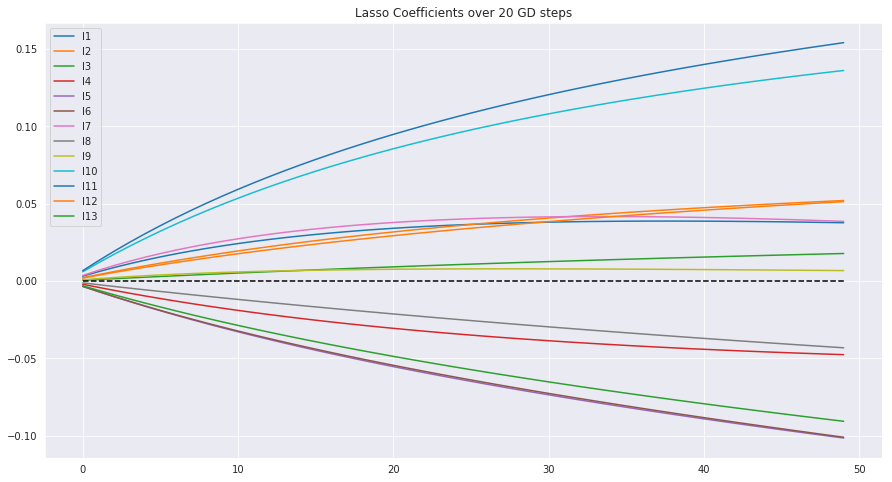

In [509]:
def plotCoeffs(models, featureNames, title):
    """
    Helper Function to show how coefficients change as we train.
    """
    fig, ax = plt.subplots(figsize = (15,8))
    X = list(range(len(models)))
    for data, name in zip(models.T, featureNames):
        if name == "Bias":
            continue
        ax.plot(X, data, label=name)
    ax.plot(X,[0]*len(X), 'k--')
    plt.title(title)
    plt.legend()
    plt.show
    
# use if starting with the models with the missing data features
#plotCoeffs(lasso_models, ['Bias'] + numeric_features + missing, "Lasso Coefficients over 50 GD steps")

# use if starting with the model where NA rows were dropped
plotCoeffs(lasso_models, ['Bias'] + numeric_features, "Lasso Coefficients over 20 GD steps")

In [513]:
def sigmoid(row):
    sig = []
    for z in row:
        sig.append(1/(1+np.exp(-z)))
    return sig

def decision_boundary(prob):
    return 1 if prob >= .5 else 0

def classify(predictions):
    '''
    input  - N element array of predictions between 0 and 1
    output - N element array of 0s (False) and 1s (True)
    '''
    classifications = []
    for prediction in predictions:
        classifications.append(decision_boundary(prediction))
    return classifications

def calc_accuracy(predicted_labels, actual_labels):
    error_count = 0
    num_predictions = len(actual_labels)
    for compare in range(num_predictions):
        if predicted_labels[compare] != actual_labels[compare]:
            error_count += 1
    return 1.0 - (float(error_count) / num_predictions)

def compare(x,y):
    return int(x != y)

coeffs = best_lasso[1:] # coefficients
b = best_lasso[0] # bias term
actual_labels = testRDD.map(lambda x: x[1]).collect()

# spark version
#error_count = testRDD.map(lambda x: (np.dot(coeffs, x[0])+b, x[1])) \
#                    .map(lambda x: (1/(1+np.exp(-x[0])), x[1])) \
#                    .map(lambda x: (decision_boundary(x[0]), x[1])) \
#                    .map(lambda x: (compare(x[0],x[1]),1)) \
#                    .reduce(lambda x,y: (x[0]+y[0],x[1]+y[1]))
#
#print("accuracy is", 1.0 - (float(error_count[0]) / error_count[1]))
# regular version
mxb = testRDD.map(lambda x: np.dot(coeffs, x[0])+b).collect() # mx+b
probabilities = sigmoid(mxb) # put through sigmoid
predictions = classify(probabilities) # put through a decision boundary
print ("accuracy is", calc_accuracy(predictions, actual_labels))

accuracy is 0.7462929374248797


In [ ]:
def calc_metrics(predicted_labels, actual_labels):
    FP = 0
    FN = 0
    TP = 0
    TN = 0
    num_predictions = len(actual_labels)
    for compare in range(num_predictions):
        if predicted_labels[compare] == actual_labels[compare]:
            if actual_labels[compare] == 0:
                TN += 1
            else:
                TP +=1
        else:
            if actual_labels[compare] == 0:
                FP +=1
            else:
                FN +=1
    return(FP,FN,TP,TN)

def acc_precision_recall_f1(FP,FN,TP,TN):
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    f1 = 2*(recall * precision) / (recall + precision)
    acc = (TP+TN)/(TP+FP+FN+TN)
    return(precision,recall,f1,acc)

In [ ]:
FP,FN,TP,TN = calc_metrics(predictions,actual_labels)
print("FP: {},FN: {}, TP: {}, TN:{}".format(FP,FN,TP,TN))
precision,recall,f1,acc =  acc_precision_recall_f1(FP,FN,TP,TN) 
print("Precision: {} Recall: {} F1: {} Accuracy: {}".format(precision,recall,f1,acc))

FP: 125811,FN: 2201178, TP: 147696, TN:6697267
Precision: 0.5400081167940857 Recall: 0.06287949034303245 F1: 0.11264267091623986 Accuracy: 0.7462929374248797


### Challenges uncovered in the EDA

* **Dimensionality.** We start with 45 million rows x 39 features. If we were to one hot encode all the distinct values of our categorical variables, the dimensions would be approx. 45 million rows x 33 million features. We need to figure out a way to reduce the feature space. 

* **Null values.** This is a sparse dataset, meaning there are a lot of nulls. We want to try logistic regression, but that means we will need to handle the nulls. But since there are so many nulls, we will also try decision trees, which can automatically handle null values. 

* **No amazing correlations.** No one feature seems to be highly correlated with the outcome, so there isn't an obvious way to pick a few features and get a good enough model. 

## 4: Algorithm Implementation

_Develop a 'homegrown' implementation of the algorithn, apply it to the training dataset and evaluate your results on the test set._

### Applying Logistic Regression on Categorical Variables

In this section, we will continue using logistic regression and now include the categorical variables. 

Initially, we will explore a 100,000-row sample dataset out of the original 45 million samples. To test the performance of our classifiers, we split 80% of the sample dataset into train data (80,000), 10% into validation data (10,000) and the remaining 10% for the final test data (10,000). 

#### Features Engineering (One Hot Encoding Vs Features Hashing) 

Each sample has `40` variables. The first variable or the column is the label: `1` or `0` to indicate the clicking event, `1` being the clicked activity. The remaining `39` variables are features, of which `13` are represented in numeric value and the rest `26` are represented in hashed value. Some of them have missing values. All features are categorical features. In order to capture all the features, we will explore the most common feature engineering methods for categorical variables: **one hot encoding (OHE)** and **feature hashing**. 

#### 1. One Hot Encoding (OHE)

As the name suggests, one hot encoding (OHE) expands all the unique features in the dataset. 

```
|         | feature1 | feature2 | feature3 | 
|---------|----------|----------|----------|
|sample 1 | black    | round    | matte    |
|sample 2 | white    | square   | shiny    |
|sample 3 | blue     | round    | matte    |
|sample 4 | black    | round    | shiny    | 


|         |black |white |blue ||round |square ||matte  |shiny | 
|---------|------|------|-----||------|-------||-------|------|
|sample 1 | 1    | 0    | 0   || 1    |  0    || 1     | 0    |  
|sample 2 | 0    | 1    | 0   || 0    |  1    || 0     | 1    |
|sample 3 | 0    | 0    | 1   || 1    |  0    || 1     | 0    | 
|sample 4 | 1    | 0    | 0   || 1    |  0    || 0     | 1    | 


index    = [0, 1, 2, 3, 4, 5, 6]
--------------------------------
sample 1 = [1, 0, 0, 1, 0, 1, 0] 
sample 2 = [0, 1, 0, 0, 1, 0, 1]
sample 3 = [0, 0, 1, 1, 0, 1, 0]
sample 4 = [1, 0, 0, 1, 0, 0, 1]
```

The advantage of one hot encoding is when the dataset is relatively small, it is convenient to capture all the unique features. We can also create a sparse vector to represent our dataset in a more compact fashion. However, one hot encoding becomes computationaly expensive when the dataset is extremely large. That is the case with our Criteo Kaggle dataset, which comes with 45 millions samples and at least 30 millions unique categorical values. 

The other disadvantage of one hot encoding is that in order to capture all the unique features, we need to have a single pass over the entire dataset, which makes the computation more expensive for the large data. However, we will use one hot encoding in our exploratory data analysis and compare with features hashing method described below. 

In [8]:
# I changed the sampleRDD into trainRDD but left the `sampleRDD1` name intact 
# because I don't want to change all other variable name.

sampleRDD1 = trainRDD.map(lambda x: x.replace('\t', ','))

# Splitting the data
# I'm splitting the original 45 million data,
weights = [0.7, 0.15, 0.15]
seed = 42
# Use randomSplit with weights and seed
TrainData, ValData, TestData = sampleRDD1.randomSplit(weights,seed)

# count the data
nTrain = TrainData.count()
nVal = ValData.count()
nTest = TestData.count()
print("Number of train data: ", nTrain)
print("Number of val data  : ", nVal)
print("Number of test data : ", nTest)
print("number of total data: ", nTrain + nVal + nTest)
print(sampleRDD1.take(1))

Number of train data:  32085274
Number of val data  :  6876749
Number of test data :  6878594
number of total data:  45840617
['0,1,1,5,0,1382,4,15,2,181,1,2,,2,68fd1e64,80e26c9b,fb936136,7b4723c4,25c83c98,7e0ccccf,de7995b8,1f89b562,a73ee510,a8cd5504,b2cb9c98,37c9c164,2824a5f6,1adce6ef,8ba8b39a,891b62e7,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,,3a171ecb,c5c50484,e8b83407,9727dd16']



This is a step-by-step walk through on how we developed our homegrown implementation of one hot encoding in a parallel computing context. Since our dataset is very large, in order to capture all the unique features, we first employed the one hot encoding approach for our small dataset `100,000` samples. 

### Step by step walk through to create one hot encoding

One sample 
```
['0,1,1,5,0,1382,4,15,2,181,1,2,,2,68fd1e64,80e26c9b,fb936136,7b4723c4,25c83c98,7e0ccccf,de7995b8,1f89b562,a73ee510,a8cd5504,b2cb9c98,37c9c164,2824a5f6,1adce6ef,8ba8b39a,891b62e7,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,,3a171ecb,c5c50484,e8b83407,9727dd16']
```
#### Step 1 (Features selection) 

Remove the first column, i.e., label `1` or `0`. 

```
['0']
[1,1,5,0,1382,4,15,2,181,1,2,,2,68fd1e64,80e26c9b,fb936136,7b4723c4,25c83c98,7e0ccccf,de7995b8,1f89b562,a73ee510,a8cd5504,b2cb9c98,37c9c164,2824a5f6,1adce6ef,8ba8b39a,891b62e7,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,,3a171ecb,c5c50484,e8b83407,9727dd16']
```

#### Step 2 (Index each feature)

Assign the remaining `39` variables with corresponding indexes. This step is critical because we will then use the index as our keys and in the reducer step, we could count how many unique features exists in each index.  

```
[[(0, '1'),      # index 0, feature 1 with the category '1'
  (1, '1'),
  (2, '5'),
  (3, '0'),
  (4, '1382'), ...],
 [(0, '5'),      # index 0, feature 1 with the category '5'
  (1, '10'), 
  (2, '34'), ...], ...,
  []]
```

#### Step 3 (Select unique) 

The index `0` can have many features. For example: 

```
(0, '1')
(0, '5')
(0, '15')
(0, '8')
(0, '1')      --> (already had above), will be removed by distinct()
(0, '15')     --> (already had above), will be removed by distinct() 
...
```
To count the unique features for each index, we will use `distinct()`. Distinct() step will be expensive especially when the data is very large. 

#### Step 4 [Optional] (Mapper and Reducer stage) 

1. Map every index and emit them with `1` so that we can reduce them. 
2. Reduce by (lambda x, y: x + y) 

```
[(0, 145),
 (1, 2483),
 (2, 864),
 (3, 130),
 (4, 20352),
 ...
```

There are 145 unique categories for the index `0`, which is the first feature out of `39` features in our sample. 

#### Step 4 (Create One Hot Dictionary) 

We need to create an index dictionary for all the unique features. Once we have the dictionary, we then go over all the samples and create a sparse vector based on what features each sample has. 

```
1. zipWithIndex() will create an index for every items
2. The emitted from above will become the tuple with the index starting from `0`.
3. [((0, '1'), 0), ((4, '1382'), 1), ((7, '2'), 2), ((13, '68fd1e64'), 3), ((14, '80e26c9b'), 4), ...]
4. collectAsMap() will create a dictionary by mapping the first [0] in a tuple and makes them as keys (composite key)
5. the index becomes the dict value

{(0, '1'): 0,
 (4, '1382'): 1,
 (7, '2'): 2,
 (13, '68fd1e64'): 3,
 ...,
 ...,
 (36, '9a1c7e3d'): 234358}
```

#### Step 5 (One Hot Encoding) 

In order to pipeline our RDD into our classifiers in later steps. Spark has a LabeledPoint which requires label in its tuple index`[0]` position. The index`[1]` has the sparse vector format. Reference <a href="https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html?highlight=labeledpoint">here</a>. This is what we try to achieve from our RDD sample. 

```
[LabeledPoint(0.0, (234358,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,117215,117216,117217,117218,117219,117220,117221,117222,117223,117224,117225,117226,117227,117228,117229,117230,117231,117232,117233,117234,117235],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]))] 
```
1. The first `0.0` at tuple index`[0]` is the sample label. 
2. `234358` is the length of the vector space. 
3. The first list `[]` is the index list for all the unique features for the sample. 
4. The second list `[]` is the value of the unique features. Since this is OHE, it's `1`. 


- To achieve this, we need to feed our original RDD because we need the original label for each sample. 
- To have the sparse vector, we already created OHE dictionary in Step 4. We will then create our sample into `(index, category)` format, and search in our OHE dictionary for their corresponding index.  

#### Step 6 (Classifiers) 

We will use logistic regression because our label is a binary classification, either `1` or `0`. We will then use a log loss function as to check our model performance. A general rule of thumb is the nearer the log loss value is to zero, the more accurate our model is. 

In [38]:
def indexFeatures(line):
    #  select feature of interest after removing the first column which is the label

    features = []

    for index,feature in enumerate(line.split(',')[1:]):
        idxFeat = index,feature
        features.append(idxFeat)
        
    return features

In [12]:
# This is indexing all the features 

start = time.time()

indexedTrainFeat = TrainData.map(indexFeatures)

totalCat = (indexedTrainFeat
            .flatMap(lambda x: x)
            .distinct()
            .map(lambda x: (x[0], 1))
            .reduceByKey(lambda x, y: x + y)
            .sortByKey()
            .collect())

print(totalCat)
print("Time taken : {} seconds".format(time.time() - start))

[(0, 140), (1, 2378), (2, 813), (3, 127), (4, 18849), (5, 1817), (6, 560), (7, 123), (8, 1724), (9, 8), (10, 84), (11, 65), (12, 244), (13, 457), (14, 491), (15, 32275), (16, 19453), (17, 127), (18, 11), (19, 6977), (20, 219), (21, 3), (22, 9243), (23, 3593), (24, 30531), (25, 2700), (26, 26), (27, 4643), (28, 25973), (29, 9), (30, 2325), (31, 1174), (32, 4), (33, 28682), (34, 10), (35, 14), (36, 10034), (37, 49), (38, 7717)]
Time taken : 4.247509479522705 seconds


In [112]:
# [features_list[i] for i in [1, 2, 4, 5, 8, 15, 16, 19, 22, 23, 24, 27, 28, 30, 31, 33, 36, 38]]   --> logloss 0.505 on test
# [features_list[i] for i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]]                           --> logloss 0.485 on test
# [features_list[i] for i in range(14, 39)]               # categorical features                    --> logloss 0.531 on test
# [features_list[i] for i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 17, 19, 27, 29, 34]]       --> logloss 0.520 on test
def selectFeatures(line):
    #  index each feature after removing the first column which is the label

    features = []

    features_list = line.split(',')[1:]
    selected_features = [features_list[i] for i in [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]] 
    for index,feature in enumerate(selected_features):
        idxFeat = index,feature
        features.append(idxFeat)
        
    return features

In [113]:
# This is selecting features which have more than 1000 unique categories in each feature

start = time.time()

indexedTrainFeat = TrainData.map(selectFeatures)

totalCat = (indexedTrainFeat
            .flatMap(lambda x: x)
            .distinct()
            .map(lambda x: (x[0], 1))
            .reduceByKey(lambda x, y: x + y)
            .sortByKey()
            .collect())

print(totalCat)
print("Time taken : {} seconds".format(time.time() - start))

[(0, 8741), (1, 450), (2, 424238), (3, 10553), (4, 3790), (5, 1196), (6, 6731), (7, 13), (8, 166), (9, 376), (10, 1161)]
Time taken : 201.2898724079132 seconds


In [114]:
# Counting total number of categories
start = time.time()
total = 0
for item in totalCat:
    total += item[1]
print("Total number of unique categories for all features: ", total)
print("Time taken : {} seconds".format(time.time() - start))

Total number of unique categories for all features:  457415
Time taken : 0.0005197525024414062 seconds


#### Unique features analysis 

1. There are `28,728,198` unique features extracted from the train dataset 0.8 * 45 = 36 million dataset using one hot encoding. Since it crashes in the later step, I reduced  the training dataset into 0.5 * 45 = 22.5 million dataset, which gave us `19,733.119` unique features. Since the computer crashes, I further reduced the training size to `4.1` million dataset. 

In [43]:
def createOHEDict(dataRDD):
    """ This is an function to create one hot encoding (OHE) dictionary 
    on the entire dataset. To make sure there's a unique number of categories for each feature,
    it will use the distinct() function. """
    
    OHEDict = (dataRDD.map(indexFeatures)
                       .flatMap(lambda x: x)
                       .distinct()
                       .zipWithIndex()
                       .collectAsMap())
    return OHEDict

In [115]:
# Creating OHEDict for selected features only 

def createOHEDict(dataRDD):
    """ This is an function to create one hot encoding (OHE) dictionary 
    on the entire dataset. To make sure there's a unique number of categories for each feature,
    it will use the distinct() function. """
    
    OHEDict = (dataRDD.map(selectFeatures)
                       .flatMap(lambda x: x)
                       .distinct()
                       .zipWithIndex()
                       .collectAsMap())
    return OHEDict

In [116]:
start = time.time()
trainOHEDict = createOHEDict(TrainData)
print("The value of (1, '') is ", trainOHEDict[(1, '')])
print("Time taken to process : {} seconds".format(time.time() - start))

trainOHEFeatures = len(trainOHEDict.keys())
print(trainOHEFeatures)

The value of (1, '') is  111430
Time taken to process : 201.84091520309448 seconds
457415


### One Hot Encoding 
#### Preparing each dataset for our classifier model

In [117]:
from pyspark.mllib.linalg import SparseVector
from pyspark.mllib.regression import LabeledPoint

def sparseOHE(feature_list, OHEDict):
    """Emitting SparseVector from the entire one hot encoding dictionary 
    for one sample data at a time
    """

    index_list = []
    
    for feat in feature_list:
        if feat in OHEDict:                     # this step is for other dataset when the unique feature might not be in the OHE dict
            index_list.append(OHEDict[feat])
        
    index_list.sort()
    
    # create a list of 1.0s for each feature
    values = [1.] * len(index_list)

    return SparseVector(len(OHEDict.keys()), index_list, values)

def parseRDD(line, OHEDict):
    """emit label, sparseVector for the sample that has been already one hot encoded. 
    label = 1 or 0 
    sparseVector = (total number of features, [list of indexes], [list of corresponding values])
    """
    features = []
    
    # split each value in the comma separated text
    for index, feature in enumerate(line.split(',')[1:]):
        idxfeat = index, feature
        features.append(idxfeat)
    
    return LabeledPoint(line.split(",")[0], sparseOHE(features, OHEDict))

In [118]:
start = time.time()
OHETrainData = TrainData.map(lambda line: parseRDD(line, trainOHEDict))
OHEValData = ValData.map(lambda line: parseRDD(line, trainOHEDict))
OHETestData = TestData.map(lambda line: parseRDD(line, trainOHEDict))
print("1st sample of feature engineered train data")
print(OHETrainData.take(1))
print("-"*50)
print("1st sample of feature engineered validation data")
print(OHEValData.take(1))
print("-"*50)
print("1st sample of feature engineered test data")
print(OHETestData.take(1))
print("-"*50)
print("Time taken to process for 3 datasets: {} seconds".format(time.time() - start))

1st sample of feature engineered train data
[LabeledPoint(0.0, (457415,[37123,72997,119774,123793,160964,182272,241862,329322,405360,409442,447770],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]))]
--------------------------------------------------
1st sample of feature engineered validation data
[LabeledPoint(0.0, (457415,[37123,78462,104587,127918,305271,392966,399792,430048,453286],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]))]
--------------------------------------------------
1st sample of feature engineered test data
[LabeledPoint(0.0, (457415,[138951,143065,199461,251540,276224,317476,366934,392966],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]))]
--------------------------------------------------
Time taken to process for 3 datasets: 20.27706527709961 seconds


### Classifiers
#### Logistic Regression on Criteo CTR Data




In [119]:
# Model definition

from pyspark.mllib.classification import LogisticRegressionWithSGD

# adjustable hyperparameters
numIters = 50
stepSize = 10.
regParam = 1e-6
regType = 'l2'
includeIntercept = True

model0 = LogisticRegressionWithSGD.train(OHETrainData,\
                                         iterations=numIters,\
                                         step=stepSize,\
                                         regParam=regParam,\
                                         regType=regType,\
                                         intercept=includeIntercept)

print("Model weights for the first 5 variables or features developed on train data\n")
sortedWeights = sorted(model0.weights)
print(sortedWeights[:5])
print("-"*50)
print("Model intercept\n")
print(model0.intercept)

Model weights for the first 5 variables or features developed on train data

[-0.6972320770426881, -0.568179574284938, -0.48932305551716265, -0.44262230014901444, -0.40318678018926674]
--------------------------------------------------
Model intercept

-0.16229626525073787


In [120]:
from pyspark.accumulators import AccumulatorParam

class FloatAccumulatorParam(AccumulatorParam):
    """
    Custom accumulator for use in page rank to keep track of various masses.
    
    IMPORTANT: accumulators should only be called inside actions to avoid duplication.
    We stringly recommend you use the 'foreach' action in your implementation below.
    """
    def zero(self, value):
        return value
    def addInPlace(self, val1, val2):
        return val1 + val2 

def calcProb(x, w, intercept):
    """Calculate the probability for an observation given a set of weights and intercept.
    Note    : We'll bound our raw prediction between 20 and -20 for numerical purposes.
    Returns : float: A probability between 0 and 1 for each sample using the model developed earlier, i.e., LogisticRegressionwithSGD
    """
    
    rawPrediction = x.dot(w) + intercept

    # Bound the raw prediction value
    rawPrediction = min(rawPrediction, 20)
    rawPrediction = max(rawPrediction, -20)
    
    # pass it through the sigmoid function
    return (1 + exp(-rawPrediction))**(-1)

def evaluateConfMatrix(model, data):
    """Calculates the log loss for the data given the model."""
    
    TP_count = sc.accumulator(0.0)
    TN_count = sc.accumulator(0.0)
    FP_count = sc.accumulator(0.0)
    FN_count = sc.accumulator(0.0)
    pred_yes = sc.accumulator(0.0)
    pred_no = sc.accumulator(0.0)
    actu_yes = sc.accumulator(0.0)
    actu_no = sc.accumulator(0.0)
    total_count = sc.accumulator(0.0)
    
    def computeAccuracy(line):
    
        p, y = line
        if y == 0:
            actu_no.add(int(1))
        else:
            actu_yes.add(int(1))
            
        threshold = 0.5 

        if p < threshold:
            p = 0
            pred_no.add(int(1))
        else: 
            p = 1
            pred_yes.add(int(1))

        if p == y: 
            if y == 1:
                TP_count.add(int(1))
            else: 
                TN_count.add(int(1))
        else: 
            if p < y:
                FN_count.add(int(1))
            else:
                FP_count.add(int(1))

        total_count.add(int(1))

        #return TP_count, TN_count, FP_count, FN_count, total_count
    
    # generate the predictions and the labels and combine them
    predictions = data.map(lambda x: calcProb(x.features, model.weights, model.intercept))
    labels = data.map(lambda x: x.label)
    pred_labels = predictions.zip(labels)
    
    # compute the log-loss, sum it, and divide by the count
    #TP, TN, FP, FN, tot = pred_labels.map(lambda x: computeAccuracy(x[0], x[1]))
    
    pred_labels.foreach(computeAccuracy)
    
    return TP_count.value, TN_count.value, FP_count.value, FN_count.value, actu_yes.value, actu_no.value, pred_yes.value, pred_no.value, total_count.value

In [121]:
from math import log
from math import exp 

def computeLogLoss(p, y):
    """Calculates the value of log loss for a given probabilty and label.
    Since log(0) is undefined, we will use a small value (epsilon). 
    """
    epsilon = 10e-12

    if p == 1:
        p = p - epsilon
    elif p == 0:
        p = p + epsilon
    
    if y == 1:
        return -log(p)
    elif y == 0: 
        return -log(1-p) 

def calcProb(x, w, intercept):
    """Calculate the probability for an observation given a set of weights and intercept.
    Note    : We'll bound our raw prediction between 20 and -20 for numerical purposes.
    Returns : float: A probability between 0 and 1 for each sample using the model developed earlier, i.e., LogisticRegressionwithSGD
    """
    
    rawPrediction = x.dot(w) + intercept

    # Bound the raw prediction value
    rawPrediction = min(rawPrediction, 20)
    rawPrediction = max(rawPrediction, -20)
    
    # pass it through the sigmoid function
    return (1 + exp(-rawPrediction))**(-1)

def evaluateResults(model, data):
    """Calculates the log loss for the data given the model."""
    
    # generate the predictions and the labels and combine them
    predictions = data.map(lambda x: calcProb(x.features, model.weights, model.intercept))
    labels = data.map(lambda x: x.label)
    pred_labels = predictions.zip(labels)
    
    # compute the log-loss, sum it, and divide by the count
    logLoss = (pred_labels.map(lambda x: computeLogLoss(x[0], x[1])) 
                .reduce(lambda x,y: x + y))/pred_labels.count()
    
    return logLoss

### Calculating the baseline for logloss

In [122]:
# calculate the overall ctr
start = time.time()
classOneFracTrain = OHETrainData.map(lambda x: x.label).reduce(lambda x,y: x + y) / OHETrainData.count()
print(classOneFracTrain)

# using the overall ctr, applies to each sample and calculate the logloss
logLossTrBase = (OHETrainData.map(lambda x: computeLogLoss(classOneFracTrain,x.label))
                             .reduce(lambda x,y: x + y))/OHETrainData.count()

print('Baseline Train Logloss = {0:.3f}\n'.format(logLossTrBase))
print("-"*50)
print("Time taken : {} seconds".format(time.time() - start))

0.25618852436790784
Baseline Train Logloss = 0.569

--------------------------------------------------
Time taken : 1168.7595541477203 seconds


### Model Performance (logloss) on the train data

In [123]:
start = time.time()

trainingPredictions = OHETrainData.map(lambda x: calcProb(x.features,model0.weights,model0.intercept))

print("Probability prediction on first 5 samples using LogisticRegression with Stochastic Gradient Descent")
print(trainingPredictions.take(5))

print("-"*50)
logLossTrLR0 = evaluateResults(model0, OHETrainData)
print('OHE Features Train Logloss:\n\tBaseline = {0:.3f}\n\tLogistic Regression model = {1:.3f}'.format(logLossTrBase, logLossTrLR0))
print("-"*50)
print("Time taken : {} seconds".format(time.time() - start))

Probability prediction on first 5 samples using LogisticRegression with Stochastic Gradient Descent
[0.3390923417343142, 0.27169162142502234, 0.35318696326326177, 0.19172669015477942, 0.5428168592407736]
--------------------------------------------------
OHE Features Train Logloss:
	Baseline = 0.569
	Logistic Regression model = 0.521
--------------------------------------------------
Time taken : 1390.7596881389618 seconds


In [124]:
# Confusion Matrix for train data
# https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/
start = time.time()

trainingPredictions = OHETrainData.map(lambda x: calcProb(x.features,model0.weights,model0.intercept))

print("Probability prediction on first 5 samples using LogisticRegression with Stochastic Gradient Descent")
print(trainingPredictions.take(5))

print("-"*50)
TP, TN, FP, FN, actu_yes, actu_no, pred_yes, pred_no, tot = evaluateConfMatrix(model0, OHETrainData)
print('OHE Confusion Matrix')
print("True Positives  : ", TP)
print("True Negatives  : ", TN)
print("False Positives : ", FP)
print("False Negatives : ", FN)
print("Total samples   : ", tot)
print("-"*50)
print("Accuracy              : ", (TP+TN)/tot)
print("Precision             : ", TP/pred_yes)
print("Sensitivity or Recall : ", TP/actu_yes)
print("Specificity           : ", TN/actu_no)
print("F1-score              : ", (2 * TP/pred_yes * TP/actu_yes)/((TP/pred_yes) + (TP/actu_yes)))
print("-"*50)
print("Time taken : {} seconds".format(time.time() - start))

Probability prediction on first 5 samples using LogisticRegression with Stochastic Gradient Descent
[0.3390923417343142, 0.27169162142502234, 0.35318696326326177, 0.19172669015477942, 0.5428168592407736]
--------------------------------------------------
OHE Confusion Matrix
True Positives  :  1110200.0
True Negatives  :  23068865.0
False Positives :  796530.0
False Negatives :  7109679.0
Total samples   :  32085274.0
--------------------------------------------------
Accuracy              :  0.7535876115628621
Precision             :  0.5822533866882044
Sensitivity or Recall :  0.13506281540154058
Specificity           :  0.9666240596478709
F1-score              :  0.21926392141732734
--------------------------------------------------
Time taken : 721.3520448207855 seconds


### Validation dataset to check the model performance

Since we have developed out model on the train dataset, we will use the model on validation dataset and check the performance, i.e., logloss. If need be, we'd go back to the model, fine tune the hyperparameters to bring the logloss as near as zero. 

In [91]:
start = time.time()
logLossValBase = OHEValData.map(lambda x: computeLogLoss(classOneFracTrain,x.label))\
.reduce(lambda x,y: x + y) / OHEValData.count()

logLossValLR0 = evaluateResults(model0,OHEValData)
print ('OHE Features Validation Logloss:\n\tBaseline = {0:.3f}\n\tLogistic Regression model = {1:.3f}'
       .format(logLossValBase, logLossValLR0))
print("-"*50)
print("Time taken : {} seconds".format(time.time() - start))

OHE Features Validation Logloss:
	Baseline = 0.569
	Logistic Regression model = 0.522
--------------------------------------------------
Time taken : 750.2806689739227 seconds


In [76]:
# Confusion Matrix 
start = time.time() 

TP, TN, FP, FN, actu_yes, actu_no, pred_yes, pred_no, tot = evaluateConfMatrix(model0, OHEValData)
print('OHE Confusion Matrix')
print("True Positives  : ", TP)
print("True Negatives  : ", TN)
print("False Positives : ", FP)
print("False Negatives : ", FN)
print("Total samples   : ", tot)
print("-"*50)
print("Accuracy              : ", (TP+TN)/tot)
print("Precision             : ", TP/pred_yes)
print("Sensitivity or Recall : ", TP/actu_yes)
print("Specificity           : ", TN/actu_no)
print("F1-score              : ", (2 * TP/pred_yes * TP/actu_yes)/((TP/pred_yes) + (TP/actu_yes)))
print("-"*50)
print("Time taken : {} seconds".format(time.time() - start))

OHE Confusion Matrix
True Positives  :  245289.0
True Negatives  :  4940261.0
False Positives :  171812.0
False Negatives :  1519387.0
Total samples   :  6876749.0
--------------------------------------------------
Accuracy              :  0.7540699827781994
Precision             :  0.5880805847984062
Sensitivity or Recall :  0.13899945372408307
Specificity           :  0.9663909337757892
--------------------------------------------------
Time taken : 270.4708082675934 seconds


In [92]:
start = time.time()
logLossTestBase = OHETestData.map(lambda x: computeLogLoss(classOneFracTrain,x.label))\
.reduce(lambda x,y: x + y) / OHETestData.count()

logLossTestLR0 = evaluateResults(model0,OHETestData)
print ('OHE Features Validation Logloss:\n\tBaseline = {0:.3f}\n\tLogistic Regression model = {1:.3f}'
       .format(logLossTestBase, logLossTestLR0))
print("-"*50)
print("Time taken : {} seconds".format(time.time() - start))

OHE Features Validation Logloss:
	Baseline = 0.569
	Logistic Regression model = 0.521
--------------------------------------------------
Time taken : 750.9118156433105 seconds


In [93]:
# Confusion matrix for Test Data

TP, TN, FP, FN, actu_yes, actu_no, pred_yes, pred_no, tot = evaluateConfMatrix(model0, OHETestData)
print('OHE Confusion Matrix')
print("True Positives  : ", TP)
print("True Negatives  : ", TN)
print("False Positives : ", FP)
print("False Negatives : ", FN)
print("Total samples   : ", tot)
print("-"*50)
print("Accuracy              : ", (TP+TN)/tot)
print("Precision             : ", TP/pred_yes)
print("Sensitivity or Recall : ", TP/actu_yes)
print("Specificity           : ", TN/actu_no)
print("F1-score              : ", (2 * TP/pred_yes * TP/actu_yes)/((TP/pred_yes) + (TP/actu_yes)))
print("-"*50)
print("Time taken : {} seconds".format(time.time() - start))

OHE Confusion Matrix
True Positives  :  238258.0
True Negatives  :  4947070.0
False Positives :  170641.0
False Negatives :  1522625.0
Total samples   :  6878594.0
--------------------------------------------------
Accuracy              :  0.7538354495119206
Precision             :  0.5826817869449424
Sensitivity or Recall :  0.13530598001116487
Specificity           :  0.9666567729205499
--------------------------------------------------
Time taken : 1541.161788702011 seconds


### Conclusion from Logistic Regression using One Hot Encoding  

Our logistic regression with stochastic gradient descent performs slightly better than the baseline. We checked the baseline in such a way that the average click through rate is distributed as a probability for each sample and the performance parameter (logloss) is calculated. As the best model that can predict accurately will have the log loss of `0` value, the performance of our model is checked with the logloss function. 



### Dimensionality Reduction (PCA vs Features Hashing) 

Although both PCA and Features hashing reduce the feature space, the fundamental concept in dimensionality reduction is different in each approach. 

#### PCA (Principal Component Analysis) 

In PCA, all features are considered. However, in calculating the eigenvectors, i.e., the vectors can be multiplied with a scalar value (eigenvalue) and the resulting vector stays in the same euclidean vector space without changing the directionality. For all the eigenvectors that can be made from the given features space, the highest eigenvector is calculated based on the how many number of features contributes to the vector and gives the highest variance. The higher the variance, the more likely it is that the model can capture all the dataset. Since each eigenvectors are orthogonal to each other, every vector has a variation in feature numbers. Some vector could have `10000` features contributing to the larger percentage of the variance, while others can be just `200` features. In principle, PCA offers the most significant features in the feature spaces. 

#### Features Hashing

In contrast to PCA, features hashing is constrained by some number of features that we set. We could generously give the feature space to be $2^{15} = 32,768$, i.e., there should be `32,768` features that we want to analyze in our model development. We do not have control on which features to choose and which features to drop. Granted, if we start off with a small feature space, it's more likely that we will be dropping many features via a **hash collision** situation. 

It is also noteworthy that when the dataset is extremely large, executing PCA on millions of features is computationaly expensive and therefore features hashing is recommended.  


###  Features Hashing Concept and Details

Features hashing is one of the feature engineering methods that is extremely powerful in handling large data. It also offers a unique trait known as **"online learning"** in which the model does not need to be trained all over again due to a new dataset. The model can immediately learns in real time and update the hyperparameters as it needs. 

As the name implies, we will have a hash function to hash all the unique features in our dataset. The hash function itself is based on the modulo function, and we will need to give an ample amount of hash indexes in the beginning in order to capture all **unique** features. 

```
|         | feature1 | feature2 | feature3 | 
|---------|----------|----------|----------|
|sample 1 | black    | round    | matte    |
|sample 2 | white    | square   | shiny    |
|sample 3 | blue     | round    | matte    |
|sample 4 | black    | round    | shiny    | 
```
Imagine we don't know how many unique features exists in our dataset. But we will generously create a hash table to hold all the unique features. We will start with giving $2^3 = 8$ indexes for our dataset. 
```
|         |    list of features    | 
|---------|------------------------|
|sample 1 | [black, round, matte]  |  
|sample 2 | [white, square, shiny] |
|sample 3 | [blue, round, matte]   |
|sample 4 | [black, round, shiny]  |
```
There are a number of hash values using different bits. The most common being md5 using 128 bits, we will use md5 hash function.
```
step 1: feature = feature.encode('utf-8')                    # feature needs to be encoded
step 2: hashlib.md5(feature)                                 # hash object
step 3: hashlib.md5(feature).hexdigest()                     # hash object converted to hexadecimal format 
step 4: int(hashlib.md5(feature).hexdigest(), 16)            # converting hex to base 10 
step 5: int(int(hashlib.md5(feature).hexdigest(), 16) % 8)   # modulo to match the hash table, here 2^3 = 8
eg    : int(int(hashlib.md5('black'.encode('utf-8')).hexdigest(), 16) % 8) 

|         | index list |   
|---------|------------|
|sample 1 | [1, 2, 3]  |  
|sample 2 | [4, 0, 6]  |
|sample 3 | [7, 2, 3]  |
|sample 4 | [1, 2, 6]  |


index    = [0, 1, 2, 3, 4, 5, 6, 7]
-----------------------------------
sample 1 = [0, 1, 1, 1, 0, 0, 0, 0] 
sample 2 = [1, 0, 0, 0, 1, 0, 1, 0]
sample 3 = [0, 0, 1, 1, 0, 0, 0, 1]
sample 4 = [0, 1, 1, 0, 0, 0, 1, 0]

```
As decribed above, feature hashing also generates a one hot encoding format. By generously giving more than enough index spaces for all unique features, we avoid a **hash collision** situation. Even if it occurs in a large hash table, it should not affect the accuracy of our model. 

The most significant advantage of using feature hashing is we **don't** need to go over the entire dataset to convert the sample features into vector space. For example, the first sample 1 comes with `black, round, matte` features. We don't need to know how many unique colors are there in our dataset. It could be only `black` color or more than that. But the modulo function in hash compression will take care of all the unique features and give the index based on the remainder. Similarly, our $2^3 = 8$ hash table also takes care of `round` feature as well. 

### Features Hashing Implementation 

In [14]:
sqlContext = SQLContext(sc)

# Load a text file and convert each line to a Row.
#lines = sc.textFile("data/train50000.txt")
lines = sc.textFile("gs://midsw261/data/train.txt")

parts = lines.map(lambda l: l.split("\t"))
projectRDD = parts.map(lambda p: Row(label=int(p[0]), I1=p[1], I2=p[2],\
                    I3=p[3], I4=p[4], I5=p[5], I6=p[6],\
                    I7=p[7], I8=p[8], I9=p[9], I10=p[10],\
                    I11=p[11], I12=p[12], I13=p[13], C1=p[14], C2=p[15], C3=p[16],\
                    C4=p[17], C5=p[18], C6=p[19], C7=p[20], C8=p[21], C9=p[22],\
                    C10=p[23], C11=p[24], C12=p[25], C13=p[26], C14=p[27], C15=p[28],\
                    C16=p[29], C17=p[30], C18=p[31], C19=p[32], C20=p[33], C21=p[34],\
                    C22=p[35], C23=p[36], C24=p[37], C25=p[38], C26=p[39]))

# Infer the schema, and register the DataFrame as a table.
projectDF = sqlContext.createDataFrame(projectRDD)
projectDF.registerTempTable("projectTable")
projectDF= projectDF.withColumn("I1", projectDF["I1"].cast(IntegerType()))
projectDF= projectDF.withColumn("I2", projectDF["I2"].cast(IntegerType()))
projectDF= projectDF.withColumn("I3", projectDF["I3"].cast(IntegerType()))
projectDF= projectDF.withColumn("I4", projectDF["I4"].cast(IntegerType()))
projectDF= projectDF.withColumn("I5", projectDF["I5"].cast(IntegerType()))
projectDF= projectDF.withColumn("I6", projectDF["I6"].cast(IntegerType()))
projectDF= projectDF.withColumn("I8", projectDF["I8"].cast(IntegerType()))
projectDF= projectDF.withColumn("I9", projectDF["I9"].cast(IntegerType()))
projectDF= projectDF.withColumn("I10", projectDF["I10"].cast(IntegerType()))
projectDF= projectDF.withColumn("I12", projectDF["I12"].cast(IntegerType()))
projectDF= projectDF.withColumn("I13", projectDF["I13"].cast(IntegerType()))
projectDF= projectDF.withColumn("I7", projectDF["I7"].cast(IntegerType()))
projectDF= projectDF.withColumn("I11", projectDF["I11"].cast(IntegerType()))
projectDF= projectDF.withColumn("I1", projectDF["I1"].cast(IntegerType()))
projectDF= projectDF.withColumn("label", projectDF["label"].cast(IntegerType()))


#remove cat logs = C3, C4, C12, C16, C21 and C24 
# include - C6,C9,C14,C17,C20,C22,C23
# remove -  I3, I2, I8, I9
# remove I15 - outliers
# include - I4 & I13, I8 & I13, I7 & I11, I1 & I7
# since #I13 appears in noth I4 and I8 - include - I4,I13,I7 & I11, I1 & I7

categorical_features = ['C1','C2','C5','C6','C7','C8','C9','C10','C11','C11','C13','C14','C15','C17','C18','C19','C20','C22','C23','C25','C26']
numeric_features = ['I4','I13','I7','I11', 'I1']
label_and_numeric = ['label']+numeric_features

allcols = categorical_features + numeric_features

#numeric_features = ["I1", "I2", "I3", "I4", "I5", "I6", "I7", "I8", "I9", "I10", "I11", "I12", "I13"]
#categorical_features =  ['C6','C9','C14','C17','C20','C22','C23']
#label_and_numeric = ["label", "I1", "I2", "I3", "I4", "I5", "I6", "I7", "I8", "I9", "I10", "I11", "I12", "I13"]

In [15]:
splits=projectDF.randomSplit([0.8, 0.2],2018)
trainDF,testDF = splits
testDF.show(2)
testDF.printSchema()
cols = testDF.columns
print(cols)

+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---+--------+---+--------+---+--------+--------+---+---+--------+--------+--------+--------+--------+--------+--------+----+----+---+----+----+---+----+----+----+---+---+---+---+-----+
|      C1|     C10|     C11|     C12|     C13|     C14|     C15|     C16|     C17|     C18|C19|      C2|C20|     C21|C22|     C23|     C24|C25|C26|      C3|      C4|      C5|      C6|      C7|      C8|      C9|  I1| I10|I11| I12| I13| I2|  I3|  I4|  I5| I6| I7| I8| I9|label|
+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---+--------+---+--------+---+--------+--------+---+---+--------+--------+--------+--------+--------+--------+--------+----+----+---+----+----+---+----+----+----+---+---+---+---+-----+
|013c8fe1|233e3a0c|a7b606c4|6aaba33c|eae197fd|b28479f6|2d0bb053|b041b04a|e5ba7672|2804effd|   |421b43cd|   |723b4dfd|   |3a171ecb|b34f3128|   |   |8162da11|29998ed1|25c83c9

In [16]:
%%time

# Copied code from the cells below - Delete start from here

num_of_features = 256 # 2^8
#allcols = label_and_numeric + categorical_features
hasher = FeatureHasher(inputCols=allcols,outputCol="features",categoricalCols=categorical_features)
hasher.setNumFeatures(num_of_features)

featurizedTrain = hasher.transform(trainDF)
featurizedTrain.select("label","features").show(2,truncate=False)

featurizedTest = hasher.transform(testDF)

featurizedTest.select("features").show(2,truncate=False)

lr = LogisticRegression(labelCol="label",featuresCol="features",maxIter = 10)
lrModel = lr.fit(featurizedTrain)
print(lrModel)

predictions = lrModel.transform(featurizedTest)
predictions.show(2)

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol="label")
evaluator.evaluate(predictions)
evaluator.getMetricName()
print('Model Intercept: ', lrModel.intercept)
weights = lrModel.coefficients
weights = [(float(w),) for w in weights]  # convert numpy type to float, and to tuple
weightsDF = sqlContext.createDataFrame(weights, ["Feature Weight"])
display(weightsDF)
weightsDF.show(2)
print("Evaluator:")
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol="label")
eval = evaluator.evaluate(predictions)
print("AUC",eval)

print("Sample Distribuion :")
clicked = predictions.filter(predictions.prediction == 1.0).count()
notclicked = predictions.filter(predictions.prediction == 0.0).count()

TP = predictions.select("label", "prediction").filter("label = 0 and prediction = 0").count()

TN = predictions.select("label", "prediction").filter("label = 1 and prediction = 1").count()
FP = predictions.select("label", "prediction").filter("label = 0 and prediction = 1").count()
FN = predictions.select("label", "prediction").filter("label = 1 and prediction = 0").count()
total = predictions.select("label").count()
total = float(total)

print("Total :",total)
print("TN :",TN)
print("FP :",FP)
print("FN :",FN)
print("TP :",TP)

print("\nConfusion Matrix:")
print(TP,'\t',FP)
print(FN,'\t',TN)
print("\n")

accuracy	= (TP + TN) / total
precision   = (TP + FP) / total
recall      = (TP + FN) / total
F1		= 2/(1/precision + 1/recall)

print("Accuracy :",accuracy)
print("Precision :",precision)
print("Recall :",recall)
print("F1 :",F1)


+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|label|features                                                                                                                                                                             |
+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0    |(256,[6,34,35,36,54,55,74,79,81,86,95,115,119,140,175,183,185,199,210,213,225,231,250],[1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,4.0,1.0,1.0,1.0,1.0])|
|1    |(256,[0,32,36,37,38,46,54,56,57,61,68,81,83,86,95,109,115,153,173,175,183,199,210],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,11.0,3.0,4.0,3.0])   |
+-----+-------------------------------------------

DataFrame[Feature Weight: double]

+--------------------+
|      Feature Weight|
+--------------------+
|-0.05627587597116992|
|-0.05281664021179919|
+--------------------+
only showing top 2 rows

Evaluator:
AUC 0.6948185957767022
Sample Distribuion :
Total : 9170441.0
TN : 302040
FP : 208731
FN : 2047947
TP : 6611723

Confusion Matrix:
6611723 	 208731
2047947 	 302040


Accuracy : 0.7539182684889418
Precision : 0.7437432943519292
Recall : 0.9443024604814534
F1 : 0.8321085146088715
CPU times: user 540 ms, sys: 224 ms, total: 764 ms
Wall time: 17min 23s


### Logistic Regression, Decision Tree, Random Forest Classifiers with DataFrames
 

#### Prep the Data

In [11]:

weights = [.8, .2]
seed = 4

stages = []
stages = pipeline_stages(categorical_features,numeric_features)

keep_cols = categorical_features + label_and_numeric
projectDF = projectDF.select([c for c in projectDF.columns if c in keep_cols])
#Handle empty strings by imputing 'EMPTY'
for c in projectDF.columns:
    projectDF = projectDF.replace(' ',str('EMPTY'), c)
    projectDF = projectDF.replace('',str('EMPTY'), c)
#Set NA's to 0
projectDF = projectDF.na.fill(0)

#OHE -> VectorAssembler
t_lr_prep = time.time()
preppedDF = apply_pipeline(projectDF,stages)
train,test = preppedDF.randomSplit(weights,seed)
print('Time to prep LR Data :', time.time() - t_lr_prep)

Time to prep LR Data : 496.0570321083069


In [13]:
train.show(1)
test.show(1)

+--------+--------+--------+--------+--------+--------+--------+---+---+---+---+---+-----+-------+--------------+-------+-------------+--------+--------------+--------+--------------+--------+-------------+--------+--------------+--------+--------------+--------------------+
|     C14|     C17|     C20|     C22|     C23|      C6|      C9| I1|I11|I13| I4| I7|label|C6Index|    C6classVec|C9Index|   C9classVec|C14Index|   C14classVec|C17Index|   C17classVec|C20Index|  C20classVec|C22Index|   C22classVec|C23Index|   C23classVec|            features|
+--------+--------+--------+--------+--------+--------+--------+---+---+---+---+---+-----+-------+--------------+-------+-------------+--------+--------------+--------+--------------+--------+-------------+--------+--------------+--------+--------------+--------------------+
|051219e6|07c540c4|5840adea|78e2e389|32c7478e|fe6b92e5|a73ee510|  3|  1|  3|  3|  3|    0|    2.0|(24,[2],[1.0])|    0.0|(3,[0],[1.0])|     5.0|(27,[5],[1.0])|     1.0|(10,

### Logistic Regression

In [14]:
#Logistic Regression
t_lr = time.time()
lrModel = LogisticRegression().fit(train)

print('Total training time - Logistic Regression : ',time.time()-t_lr)
predictions_lr = lrModel.transform(test)
# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction",labelCol="label")


Total training time - Logistic Regression :  172.82883667945862


In [15]:
#LR Predictions
#predictions_lr.groupBy('prediction').count().show()

TP = predictions_lr.select("label", "prediction").filter("label = 1 and prediction = 1").count()

TN = predictions_lr.select("label", "prediction").filter("label = 0 and prediction = 0").count()
FP = predictions_lr.select("label", "prediction").filter("label = 0 and prediction = 1").count()
FN = predictions_lr.select("label", "prediction").filter("label = 1 and prediction = 0").count()
total = predictions_lr.select("label").count()
total = float(total)

print("Total :",total)
print("TN :",TN)
print("FP :",FP)
print("FN :",FN)
print("TP :",TP)

print("\nConfusion Matrix:")
print(TP,'\t',FP)
print(FN,'\t',TN)
print("\n")

accuracy= (TP + TN) / total
precision   = TP / (TP + FP)
recall      = TP / (TP + FN)
F1= 2/(1/precision + 1/recall)

#print('AUC ROC -',evaluator.evaluate(predictions_lr))
print("Accuracy :",accuracy)
print("Precision :",precision)
print("Recall :",recall)
print("F1 :",F1)

Total : 9170447.0
TN : 6659383
FP : 163022
FN : 2110917
TP : 237125

Confusion Matrix:
237125 	 163022
2110917 	 6659383


Accuracy : 0.752036187548982
Precision : 0.5925947214398708
Recall : 0.10098839799288088
F1 : 0.17256818945130775


In [16]:
#Prep the data for Trees (skip the one hot encoding step)
t_tree_prep = time.time()
stages = []
stages = pipeline_stages(categorical_features,numeric_features,OHE=False)
preppedDF = apply_pipeline(projectDF,stages)
train,test = preppedDF.randomSplit(weights,seed)
print('Total time to prep tree data :',time.time()-t_tree_prep)

Total time to prep tree data : 489.0456871986389


### Decision Tree

In [17]:
# Create initial Decision Tree Model
t_dt = time.time()
dtModel = DecisionTreeClassifier(
    labelCol="label", featuresCol="features", maxDepth=3).fit(train)
print('Total Training Time - Decision Tree : ',time.time()-t_dt)
#make predictions
predictions_dt = dtModel.transform(test)
evaluator = BinaryClassificationEvaluator(
    rawPredictionCol="prediction",labelCol="label")


Total Training Time - Decision Tree :  346.78829073905945


In [18]:
# DT Predictions
#predictions_dt.groupBy('prediction').count().show()

TP = predictions_dt.select("label", "prediction").filter("label = 1 and prediction = 1").count()

TN = predictions_dt.select("label", "prediction").filter("label = 0 and prediction = 0").count()
FP = predictions_dt.select("label", "prediction").filter("label = 0 and prediction = 1").count()
FN = predictions_dt.select("label", "prediction").filter("label = 1 and prediction = 0").count()
total = predictions_dt.select("label").count()
total = float(total)

print("Total :",total)
print("TN :",TN)
print("FP :",FP)
print("FN :",FN)
print("TP :",TP)

print("\nConfusion Matrix:")
print(TP,'\t',FP)
print(FN,'\t',TN)
print("\n")

accuracy= (TP + TN) / total
precision   = TP / (TP + FP)
recall      = TP / (TP + FN)
F1= 2/(1/precision + 1/recall)


#print('AUC ROC -',evaluator.evaluate(predictions_dt))
print("Accuracy :",accuracy)
print("Precision :",precision)
print("Recall :",recall)
print("F1 :",F1)

Total : 9170447.0
TN : 6479945
FP : 342460
FN : 1949786
TP : 398256

Confusion Matrix:
398256 	 342460
1949786 	 6479945


Accuracy : 0.7500398835520231
Precision : 0.5376635579628359
Recall : 0.16961195753738648
F1 : 0.2578745243233688


### Random Forest

In [19]:
# Create an initial RandomForest model.
t_rf = time.time()
rfModel = RandomForestClassifier(
    labelCol="label", featuresCol="features").fit(train)

print('Total training time - Random Forrest : ',time.time()-t_rf)

#Make Predictions
predictions_rf = rfModel.transform(test)
evaluator = BinaryClassificationEvaluator(
    rawPredictionCol="prediction",labelCol="label")


Total training time - Random Forrest :  410.3529806137085


In [20]:
#RF Predictions
#predictions_rf.groupBy('prediction').count().show()

TP = predictions_rf.select("label", "prediction").filter("label = 1 and prediction = 1").count()

TN = predictions_rf.select("label", "prediction").filter("label = 0 and prediction = 0").count()
FP = predictions_rf.select("label", "prediction").filter("label = 0 and prediction = 1").count()
FN = predictions_rf.select("label", "prediction").filter("label = 1 and prediction = 0").count()
total = predictions_rf.select("label").count()
total = float(total)

print("Total :",total)
print("TN :",TN)
print("FP :",FP)
print("FN :",FN)
print("TP :",TP)

print("\nConfusion Matrix:")
print(TP,'\t',FP)
print(FN,'\t',TN)
print("\n")

accuracy= (TP + TN) / total
precision   = TP / (TP + FP)
recall      = TP / (TP + FN)
F1= 2/(1/precision + 1/recall)

#print('AUC ROC -',evaluator.evaluate(predictions_rf))
print("Accuracy :",accuracy)
print("Precision :",precision)
print("Recall :",recall)
print("F1 :",F1)

Total : 9170447.0
TN : 6669829
FP : 152576
FN : 2089615
TP : 258427

Confusion Matrix:
258427 	 152576
2089615 	 6669829


Accuracy : 0.7554981780059358
Precision : 0.6287715661442861
Recall : 0.11006063775690554
F1 : 0.18733076118729486


## 5 : Summary  

_Pick 3-5 key course concepts and discuss how your work on this assignment illustrates an understanding of these concepts._

Our team covered a wide swathe of the concepts we learned in the class: functional programming, map-reduce, associative and commutative properties in parallel computation, nodes communication in Spark, and other machine learning algorithms available in Spark. 

**EDA**  
Our initial exploratory data analysis (EDA) on `1000` samples involves matrix correlation, heatmap between numerical variables, chi-square test for categorical variables so as to identify which variables are important in predicting the label. The EDA revealed that we were going to encounter problems with extreme dimensionality if we simply one hot encoded all the categorical variables. As a result, we worked on some strategies to reduce the feature space, including Hashing and making strategic decisions about which features we could drop. The EDA also revealed that we had a lot of null values, and so we adopted a strategy of replacing them with mean values but also tried decision tree algorithms which can naturally work with null values. 

**Algorithms**   

**1. One Hot Encoding**

The first strategy we considered for handling categorical variables was one hot encoding. If we were to one hot encode all the categorical variables we would have been dealing with 10s of millions of unique features on top of the 45 million rows of data. That approach became computationally impractical because one hot encoding needs a single pass for the entire dataset in order to calculate how many unique features the dataset has. We then looked more closely at the categorical data and realized that some of the features accounted for most of the unique values. We could make one hot encoding practical by just taking those categorical features with less than 100 unique values. 

**2. Features Hashing**

Next our team explored another feature engineering method called features hashing, which allows us to avoid the expensive computation of one hot encoding all the categorical data. This method allowed us to adjust the number of features we want to use in our data analysis (features tables). This led us to develop a more robust and powerful model because features hashing does not require a single pass for the entire 45 million dataset in order to calculate how many unique features the dataset has. 

**3. Decision Tree, Random Forest**

Finally we explored tree based methods including Decision Tree and Random Forrest. These algorithms reduce data preprocessing time because they natively handle categorical variables and null values. One caveate here is that Spark's ML package does not accept string values in the input data so a pass over the data was required in order to label encode each categorical string value.

**Model Comparison**

The following table summarizes the results of each model. The models are listed in descending order of efficiency from left to right (most-efficient model is on the left, least-efficient is on the right).

|	Model	|	LR-FH-ML	|	LR-OHE-ML	|	LR-OHE-MLlib	|	DT-ML	|	RF-ML	|	LR-RDD-Integers	|
|	------------------	|	------------------	|	------------------	|	------------------	|	------------------	|	------------------	|	------------------	|
|	Accuracy	|	0.754	|	0.755	|	0.754	|	0.75	|	0.755	|	0.746	|
|	Precision	|	0.129	|	0.629	|	0.582	|	0.538	|	0.629	|0.54		|
|	Recall	|	0.764	|	0.11	|	0.135	|	0.17	|	0.11	|0.06		|
|	F1	|	0.221	|	0.187	|	0.219	|	0.258	|	0.187	|	0.11	|
 

**Conclusion**

Throughout this project we considered, implemented, and assessed multiple strategies for tackling click through rate prediction at scale. Additionally, we assessed the relative merits of the various Spark packages, as they relate to this problem, including: RDD's, DataFrames, MLlib and ML. Finally, we considered a variety of strategies to handle the categorical variables and high cardinality inherent in this dataset. Strategies included: Careful feature selection based on EDA (Unique value counts, correlation, Chi Square test), One Hot Encoding of Categorical Variables, Feature Hashing and Tree Based models that handle categorical variables natively. Ultimately, Logistic Regression with feature hashing implemented with the Spark Ml package was both the most efficient and produced the best results. 








